In [1]:
# Author: Ayush Oturkar
# Topic: Predict Future Sales

# Data Manipulation packages
import pandas as pd
import numpy as np
import os

# Data Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from itertools import product

# For proper display of all columns
from IPython.display import display

pd.options.display.max_columns = None

# Import warnings
import warnings
warnings.filterwarnings("ignore")

# Sklearn required packages
from sklearn.preprocessing import LabelEncoder

# Import all the modelling packages
import xgboost as xgb
import lightgbm as lgb
import gc

from utility.utility_func import *

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeRegressor

import torch
import torch.nn as nn

import optuna
import pickle

# Utility Functions

Ulility functions can be found in the utlity folder under utility_func.py file

# Loading the Dataset

In [3]:
# Provide the data folder path
folder_path = "../data"

# Loading the datasets
items = pd.read_csv(os.path.join(folder_path, "items.csv"))
shops = pd.read_csv(os.path.join(folder_path, "shops.csv"))
item_cats = pd.read_csv(os.path.join(folder_path, "item_categories.csv"))
train = pd.read_csv(os.path.join(folder_path, "sales_train.csv"))

# Setting index to ID to avoid droping it later
test = pd.read_csv(os.path.join(folder_path, "test.csv")).set_index("ID")

# Creating a data dictionary for later usage -- ***Move it somewhere else**
train_data_dict = {"items": items, "shops": shops, "cats": item_cats, "train": train}

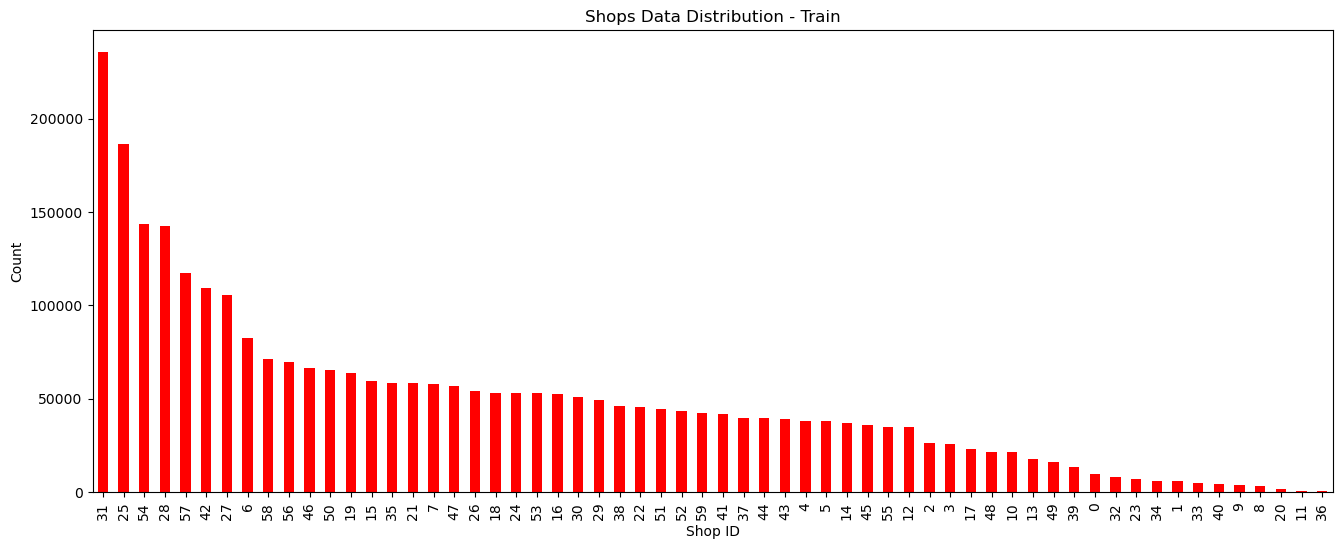

In [4]:
# Assuming items is your DataFrame and 'item_category_id' is a column in it
category_counts = train['shop_id'].value_counts()

# Plotting the histogram
plt.figure(figsize=(16, 6))
category_counts.plot(kind='bar', color='red')
plt.title('Shops Data Distribution - Train')
plt.xlabel('Shop ID')
plt.ylabel('Count')
plt.show()


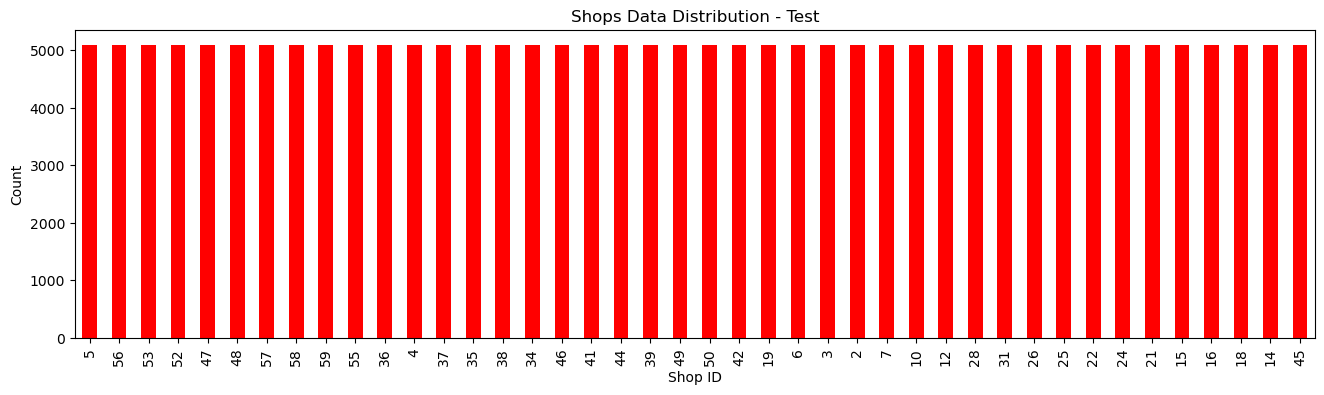

In [5]:
# Assuming items is your DataFrame and 'item_category_id' is a column in it
category_counts = test['shop_id'].value_counts()

# Plotting the histogram
plt.figure(figsize=(16, 4))
category_counts.plot(kind='bar', color='red')
plt.title('Shops Data Distribution - Test')
plt.xlabel('Shop ID')
plt.ylabel('Count')
plt.show()


In [6]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [7]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [9]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [10]:
# Taking a look at snap of data
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


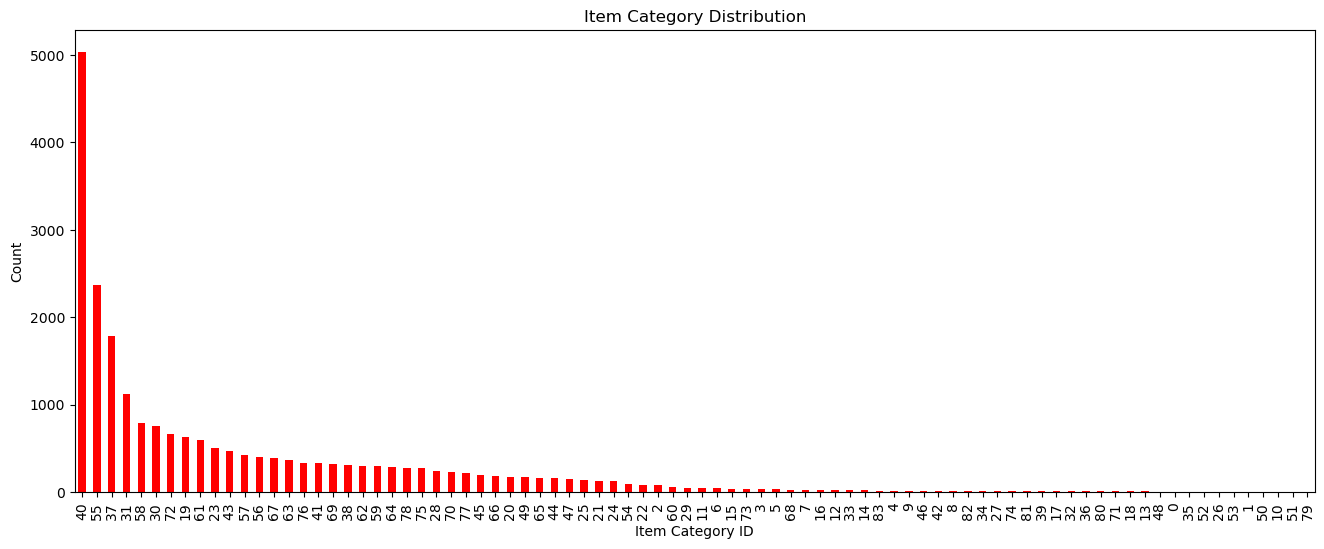

In [11]:
# Assuming items is your DataFrame and 'item_category_id' is a column in it
category_counts = items['item_category_id'].value_counts()

# Plotting the histogram
plt.figure(figsize=(16, 6))
category_counts.plot(kind='bar', color='red')
plt.title('Item Category Distribution')
plt.xlabel('Item Category ID')
plt.ylabel('Count')
plt.show()


**date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33** 
- Important variable for forecasting

**Objective: To forecast the sales for these shops and products for November 2015.**

# Data Cleaning & Pre-Processing

In [13]:
# Lets check the missing
for df, i in train_data_dict.items():
    print(
        "\n===={} data missing value count:====\n{}".format(
            df.upper(), missing_val_check(i)
        )
    )


====ITEMS data missing value count:====
                  Total  Percent(%)
item_name             0         0.0
item_id               0         0.0
item_category_id      0         0.0

====SHOPS data missing value count:====
           Total  Percent(%)
shop_name      0         0.0
shop_id        0         0.0

====CATS data missing value count:====
                    Total  Percent(%)
item_category_name      0         0.0
item_category_id        0         0.0

====TRAIN data missing value count:====
                Total  Percent(%)
date                0         0.0
date_block_num      0         0.0
shop_id             0         0.0
item_id             0         0.0
item_price          0         0.0
item_cnt_day        0         0.0


In [14]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


**Check for outliers in the present numeric features**

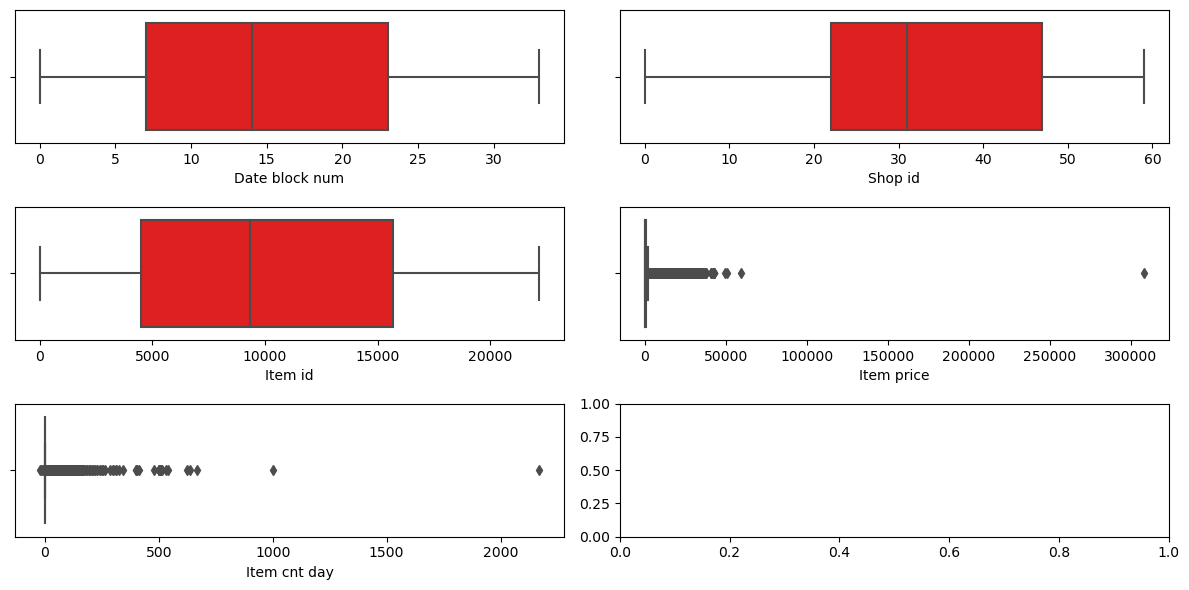

In [15]:
get_boxplots(train)

**Outlier Treatment for Enhanced Data Integrity**

Visual analysis revealed outliers within the item price and item cnt day features. To maintain data integrity and model accuracy, these outliers were addressed through a multi-pronged approach:

**Item Price:**

- Item Proce exceeding a benchmark of 50,000 will be removed based on visual observations of high price concentration.
- A minimum price threshold of 0 should be applied to ensure realistic product pricing.

**Target Variable:**

- Outliers surpassing 500 will excluded, aligning with observations of value concentration and instruction-provided clipping range.
- Subsequent clipping between 0 and 20 will be implemented to focus model training within this specified range, promoting accurate predictions.

**Trend Analysis Prior to Clipping:**

- Trend analysis was conducted before final clipping to glean potential insights from outlier patterns and assess their genuineness.

**Rationale:**

- Outlier removal and clipping safeguard model robustness and prevent undue influence from atypical values.
- Aligning feature ranges with known business constraints and expected value distributions bolsters model accuracy and interpretability.
- Trend analysis preceding clipping safeguards against premature removal of potentially informative data points.

In [17]:
# Treatment as stated
train = train.loc[
    (train["item_price"] > 0)
    & (train["item_price"] < 50000)
    & (train["item_cnt_day"] < 500)
]

gc.collect()

0

In [18]:
print(shops.head())
print("\n\n", item_cats.head())
print("\n\n", items.head())

# I saw the data hence for the clean code checking if total row count = total unique item names
print(
    "\n\n Note: Total rows in items data {} and total unique item_names {}".format(
        items.shape[0], len(items["item_name"].unique())
    )
)

                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4


         item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4


                                            item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2        

In [19]:
# Splitting shop name to get the city name
shops["city"] = shops["shop_name"].str.split(" ").map(lambda x: x[0])
shops["city"] = shops["city"].replace("!", "", regex=True)

# Label encoding so that it is more readable
shops["city_code"] = LabelEncoder().fit_transform(shops["city"])
shops.drop(["city"], axis=1, inplace=True)
shops.drop(["shop_name"], axis=1, inplace=True)

# Splitting category name to get the item type.
item_cats["item_cat_split"] = item_cats["item_category_name"].str.split("-")
item_cats["type"] = item_cats["item_cat_split"].map(lambda x: x[0].strip())
item_cats["type_code"] = LabelEncoder().fit_transform(item_cats["type"])

# Splitting category name to get the item type.
item_cats["subcat"] = item_cats["item_cat_split"].map(
    lambda x: x[1].strip() if len(x) > 1 else x[0].strip()
)
item_cats["subcat_code"] = LabelEncoder().fit_transform(item_cats["subcat"])
item_cats = item_cats[["item_category_id", "type_code", "subcat_code"]]

# Dropping item names from items df as we discussed
# Create the date the product was first sold as a feature
items["first_sale_date"] = train.groupby("item_id").agg({"date_block_num": "min"})[
    "date_block_num"
]
# Refine null values in items table
items = items.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)
items.drop(["item_name"], axis=1, inplace=True)

gc.collect()

34

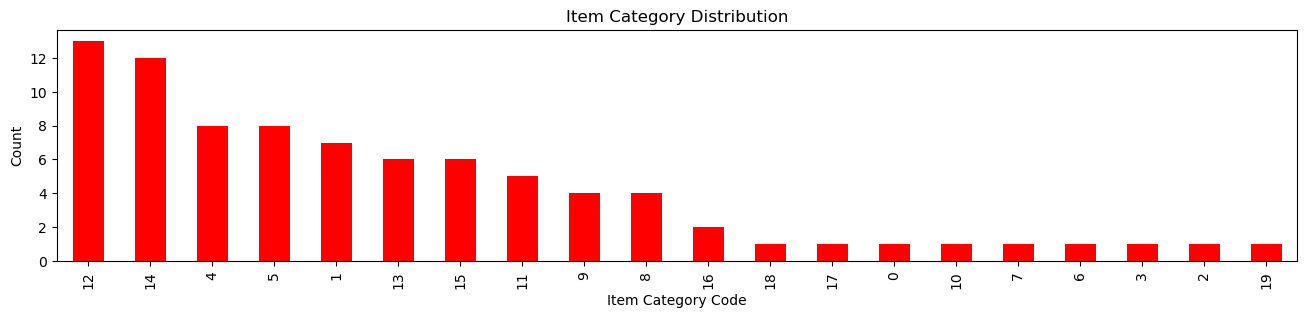

In [20]:
# Assuming items is your DataFrame and 'item_category_id' is a column in it
category_counts = item_cats['type_code'].value_counts()

# Plotting the histogram
plt.figure(figsize=(16, 3))
category_counts.plot(kind='bar', color='red')
plt.title('Item Category Distribution')
plt.xlabel('Item Category Code')
plt.ylabel('Count')
plt.show()

**Merging suppliment data to train and test**

In [21]:
# Merge the items, shops and category data to train
train = (
    train.merge(items, on="item_id", how="left")
    .merge(shops, on="shop_id", how="left")
    .merge(item_cats, on="item_category_id", how="left")
)

# Merge the items, shops and category data to train
test = (
    test.merge(items, on="item_id", how="left")
    .merge(shops, on="shop_id", how="left")
    .merge(item_cats, on="item_category_id", how="left")
)

In [22]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,first_sale_date,city_code,type_code,subcat_code
0,02.01.2013,0,59,22154,999.00,1.0,37,0.0,30,11,1
1,03.01.2013,0,25,2552,899.00,1.0,58,0.0,13,13,27
2,05.01.2013,0,25,2552,899.00,-1.0,58,0.0,13,13,27
3,06.01.2013,0,25,2554,1709.05,1.0,58,0.0,13,13,27
4,15.01.2013,0,25,2555,1099.00,1.0,56,0.0,13,13,3


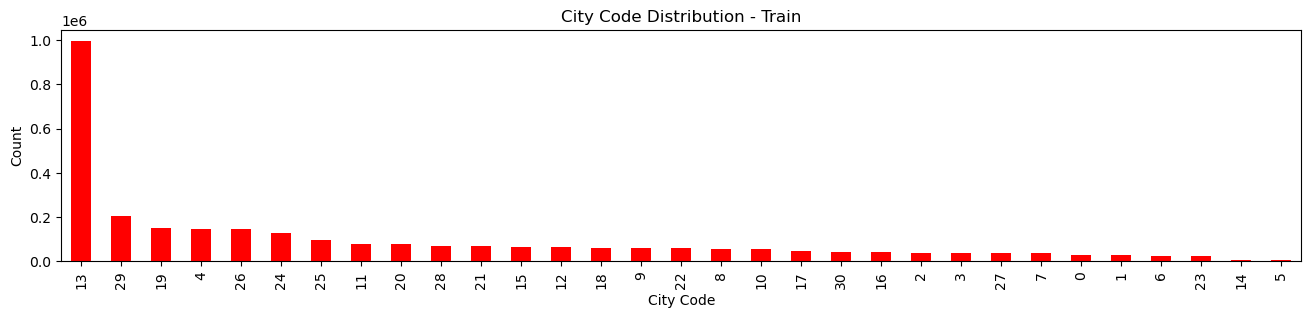

In [23]:
# Assuming items is your DataFrame and 'item_category_id' is a column in it
category_counts = train['city_code'].value_counts()

# Plotting the histogram
plt.figure(figsize=(16, 3))
category_counts.plot(kind='bar', color='red')
plt.title('City Code Distribution - Train')
plt.xlabel('City Code')
plt.ylabel('Count')
plt.show()

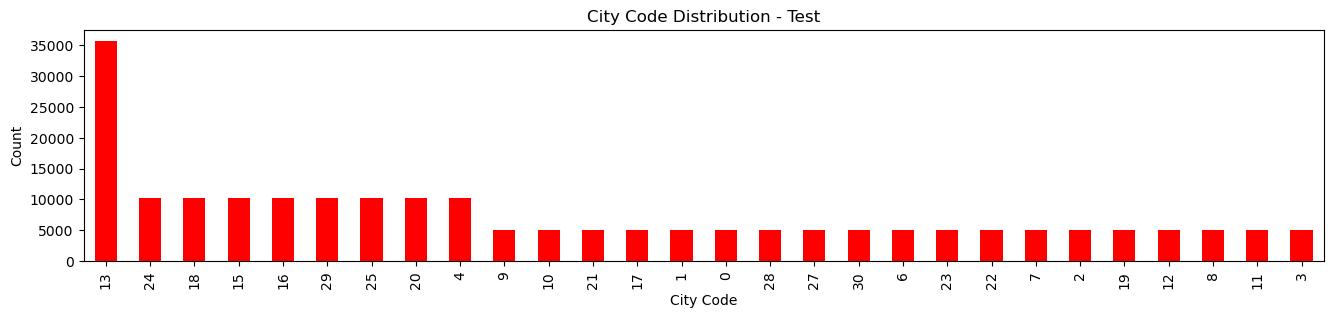

In [24]:
# Assuming items is your DataFrame and 'item_category_id' is a column in it
category_counts = test['city_code'].value_counts()

# Plotting the histogram
plt.figure(figsize=(16, 3))
category_counts.plot(kind='bar', color='red')
plt.title('City Code Distribution - Test')
plt.xlabel('City Code')
plt.ylabel('Count')
plt.show()

**Lets quickly look at our test data and see what additional item shop pairs we have.**

In [25]:
# Creating a test dummy so that we dont make any changes in test data
test_dummy = test.copy()
test_dummy["shp_itm"] = (
    test_dummy["shop_id"].astype(str) + "_" + test_dummy["item_id"].astype(str)
)
test_shp_itm_ls = list(test_dummy["shp_itm"].unique())

train["shp_itm"] = train["shop_id"].astype(str) + "_" + train["item_id"].astype(str)
trn_shp_itm_ls = list(train["shp_itm"].unique())

print("Total unique shop and item combination in the train data :", len(trn_shp_itm_ls))
print("Total unique shop and item combination in the test data:", len(test_shp_itm_ls))
print(
    "Any new shop item sales needs to be predicted:",
    str(len(list(set(test_shp_itm_ls) - set(trn_shp_itm_ls))) > 0),
)
print(
    "Total new shop item combination in the test data",
    str(len(list(set(test_shp_itm_ls) - set(trn_shp_itm_ls)))),
)

Total unique shop and item combination in the train data : 424121
Total unique shop and item combination in the test data: 214200
Any new shop item sales needs to be predicted: True
Total new shop item combination in the test data 102797


**Information regarding the Test Set**
- In the test set, there are new item pairs added over 34 months, resulting in 102,797 unique combinations.
- For most items in the test set, the target value should be zero, as they have not been sold before.

**Strategy**
- The strategy is to calculate monthly sales in the training set and extend it with zero sales for each unique pair within the month.
- This approach ensures that the training data mimics the structure of the test data.
- To achieve this, we need to create missing records for each month, shop, and item combination in the dataset.
- The sales values for these missing records should be replaced with 0 to reflect no sales.
- The goal is to mimic the behavior of the test data, where many item pairs have zero sales.

**Grouping on month level as our we need to predict next month total sales**

In [26]:
# Groupping by month as per the requirements.
train_grp = train.groupby(
    [
        "date_block_num",
        "shop_id",
        "item_category_id",
        "item_id",
        "city_code",
        "type_code",
        "subcat_code",
    ],
    as_index=False,
)
train_month_rolled = train_grp.agg(
    {"item_price": "mean", "item_cnt_day": ["sum", "mean", "count"]}
).reset_index(drop="True")

# Rename the columns
train_month_rolled.columns = [
    "date_block_num",
    "shop_id",
    "item_category_id",
    "item_id",
    "city_code",
    "type_code",
    "subcat_code",
    "item_price",
    "item_cnt",
    "mean_item_cnt",
    "transactions",
]

# Update the test
test["item_cnt"] = 0
test["date_block_num"] = 34
cols = [
    "shop_id",
    "item_id",
    "date_block_num",
    "item_category_id",
    "city_code",
    "type_code",
    "subcat_code",
    "first_sale_date",
]
train_month_rolled = pd.concat(
    [train_month_rolled, test], ignore_index=True, sort=False, keys=cols
)

**Now lets roll this data to monthly level for analysing trends**

In [27]:
# Extract time based features.
train_month_rolled["year"] = train_month_rolled["date_block_num"].apply(
    lambda x: ((x // 12) + 2013)
)
train_month_rolled["month"] = train_month_rolled["date_block_num"].apply(lambda x: (x % 12))
train_month_rolled['month']=train_month_rolled['month']+1

# Exploratory Data Analysis

In [28]:
df = train_month_rolled[train_month_rolled['date_block_num']<34].groupby(['year', 'month'])['item_cnt'].sum().reset_index()

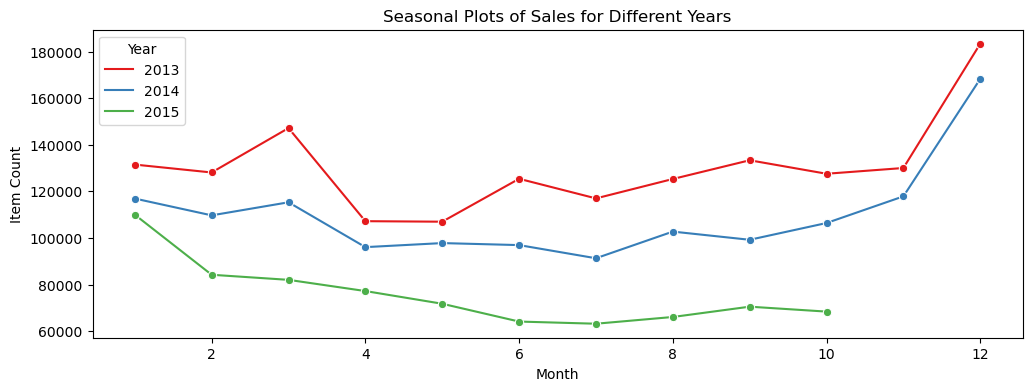

In [29]:
# Combine 'year' and 'month' columns to create a new 'date' column
df['date'] = df['year'].astype(str) + '-' + df['month'].astype(str)

# Convert 'date' to datetime format
df['date'] = pd.to_datetime(df['date'], format='%Y-%m')

# Plotting
plt.figure(figsize=(12, 4))
sns.lineplot(x='month', y='item_cnt', hue='year', data=df, palette='Set1', marker='o')
plt.title('Seasonal Plots of Sales for Different Years')
plt.xlabel('Month')
plt.ylabel('Item Count')
plt.legend(title='Year')
plt.show()

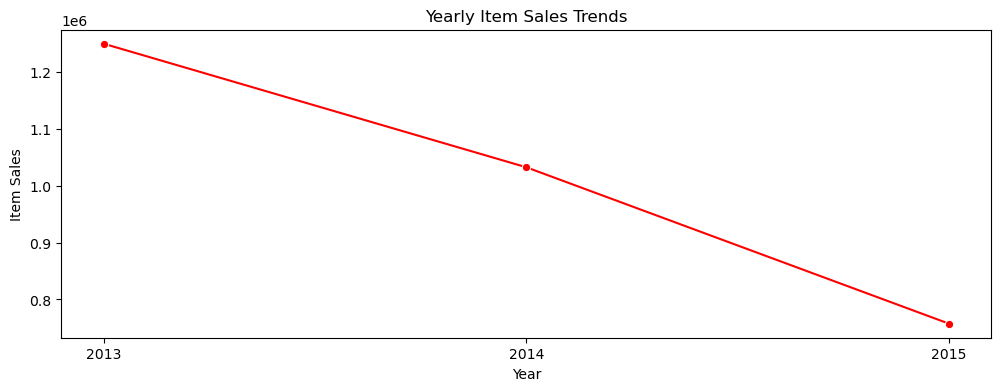

In [30]:
df = train_month_rolled[(train_month_rolled['date_block_num']<34) & (train_month_rolled['month']<=10)].groupby(['year'])['item_cnt'].sum().reset_index()

plt.figure(figsize=(12, 4))
sns.lineplot(x='year', y='item_cnt', data=df, marker='o', color='red')

plt.title('Yearly Item Sales Trends')
plt.xlabel('Year')
plt.ylabel('Item Sales')

# Set x-axis ticks to match the actual data points without interpolation
plt.xticks(df['year'].unique())

plt.show()

In [31]:
# Lets create a revenue feature to check certain trends in comparison to
train_month_rolled["revenue"] = train_month_rolled["item_price"] * train_month_rolled["item_cnt"]

In [32]:
def EDA_func(target_variable="item_cnt"):
    if target_variable == "item_cnt":
        target_name = "Quantity"
    elif target_variable == "revenue":
        target_name = "Revenue"

    # Monthly quantity plot
    monthly_quantity = train_month_rolled.groupby(["date_block_num"])[target_variable].sum().astype("float")
    
    # Monthly average item price plot
    monthly_avg_price = train.groupby(["date_block_num"])["item_price"].mean().astype("float")

    # Create a subplot with two y-axes
    fig, ax1 = plt.subplots(figsize=(20, 6))

    # Plotting quantity on the first y-axis
    ax1.set_xlabel("Time")
    ax1.set_ylabel(f"{target_name} Sales", color="tab:blue")
    ax1.plot(monthly_quantity, color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    # Creating a second y-axis for average item price
    ax2 = ax1.twinx()
    ax2.set_ylabel("Average Item Price", color="tab:orange")
    ax2.plot(monthly_avg_price, color="tab:orange")
    ax2.tick_params(axis="y", labelcolor="tab:orange")

    plt.title(f"Monthly Total {target_name} and Average Item Price")
    plt.show()

    # Grouping data for analysis
    monthly_mean_data = train_month_rolled.groupby(["month"], as_index=False)[target_variable].mean()
    monthly_sum_data = train_month_rolled.groupby(["month"], as_index=False)[target_variable].sum()

    category_mean_data = train_month_rolled.groupby(["item_category_id"], as_index=False)[target_variable].mean()
    category_sum_data = train_month_rolled.groupby(["item_category_id"], as_index=False)[target_variable].sum()

    shop_mean_data = train_month_rolled.groupby(["shop_id"], as_index=False)[target_variable].mean()
    shop_sum_data = train_month_rolled.groupby(["shop_id"], as_index=False)[target_variable].sum()

    # Plotting trends
    f, axes = plt.subplots(2, 1, figsize=(20, 6), sharex=True)
    sns.lineplot(x="month", y=target_variable, data=monthly_mean_data, ax=axes[0]).set_title(
        f"Year-Month level {target_name} mean - Trend"
    )
    sns.lineplot(x="month", y=target_variable, data=monthly_sum_data, ax=axes[1]).set_title(
        f"Year-Month level {target_name} sum - Trend"
    )
    plt.show()

    # Plotting category and shop level analysis
    f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
    sns.barplot(
        x="item_category_id", y=target_variable, data=category_mean_data, ax=axes[0]
    ).set_title(f"{target_name} Monthly mean")
    sns.barplot(
        x="item_category_id", y=target_variable, data=category_sum_data, ax=axes[1]
    ).set_title(f"{target_name} Monthly sum")
    plt.show()

    f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
    sns.barplot(x="shop_id", y=target_variable, data=shop_mean_data, ax=axes[0]).set_title(
        f"{target_name} Monthly mean at shop level"
    )
    sns.barplot(x="shop_id", y=target_variable, data=shop_sum_data, ax=axes[1]).set_title(
        f"{target_name} Monthly sum at shop level"
    )
    plt.show()

    # Plotting price vs item quantity sales
    plt.figure(figsize=(15, 5))
    sns.scatterplot(data=train_month_rolled, x="item_price", y=target_variable)
    plt.xlabel("Products AVG price")
    plt.ylabel(f"Product sales {target_name}")

    return (
        monthly_mean_data,
        monthly_sum_data,
        category_mean_data,
        category_sum_data,
        shop_mean_data,
        shop_sum_data,
    )


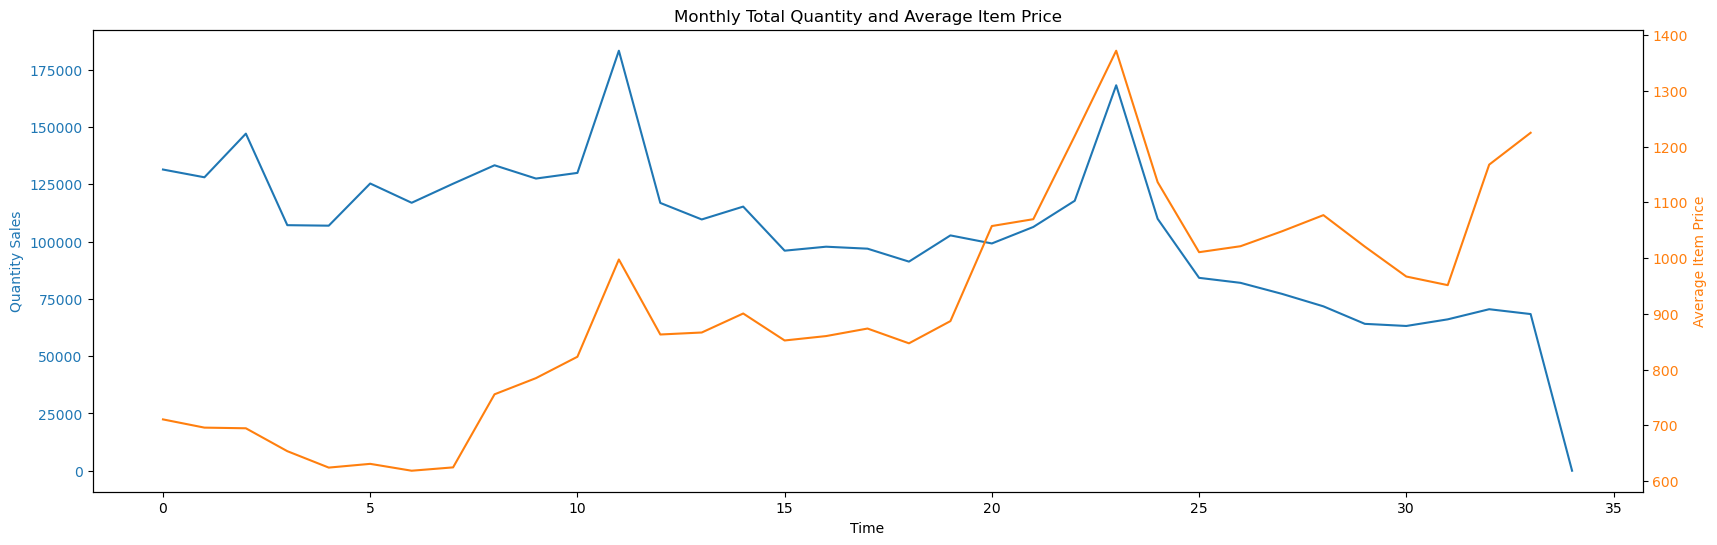

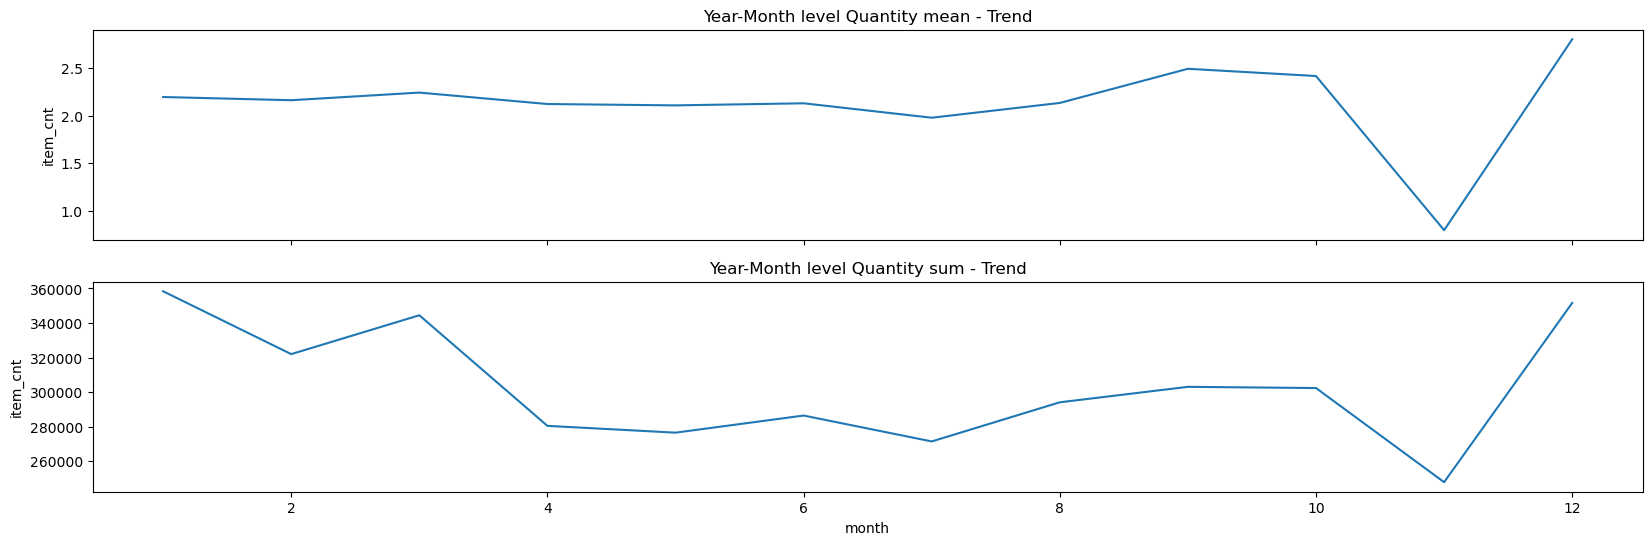

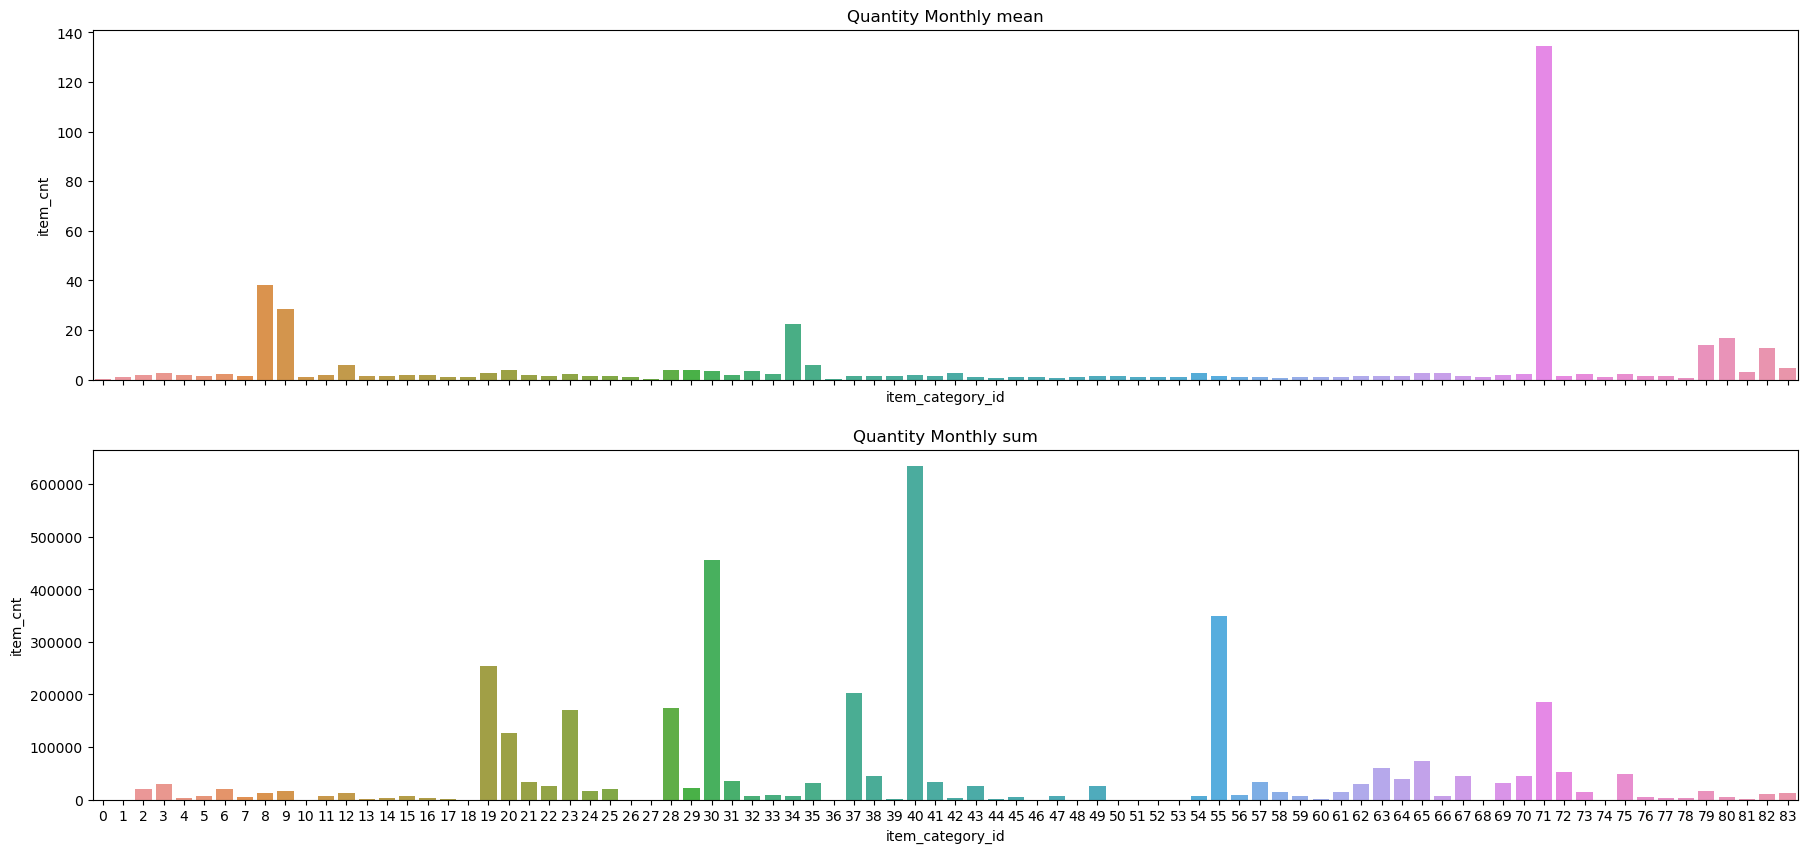

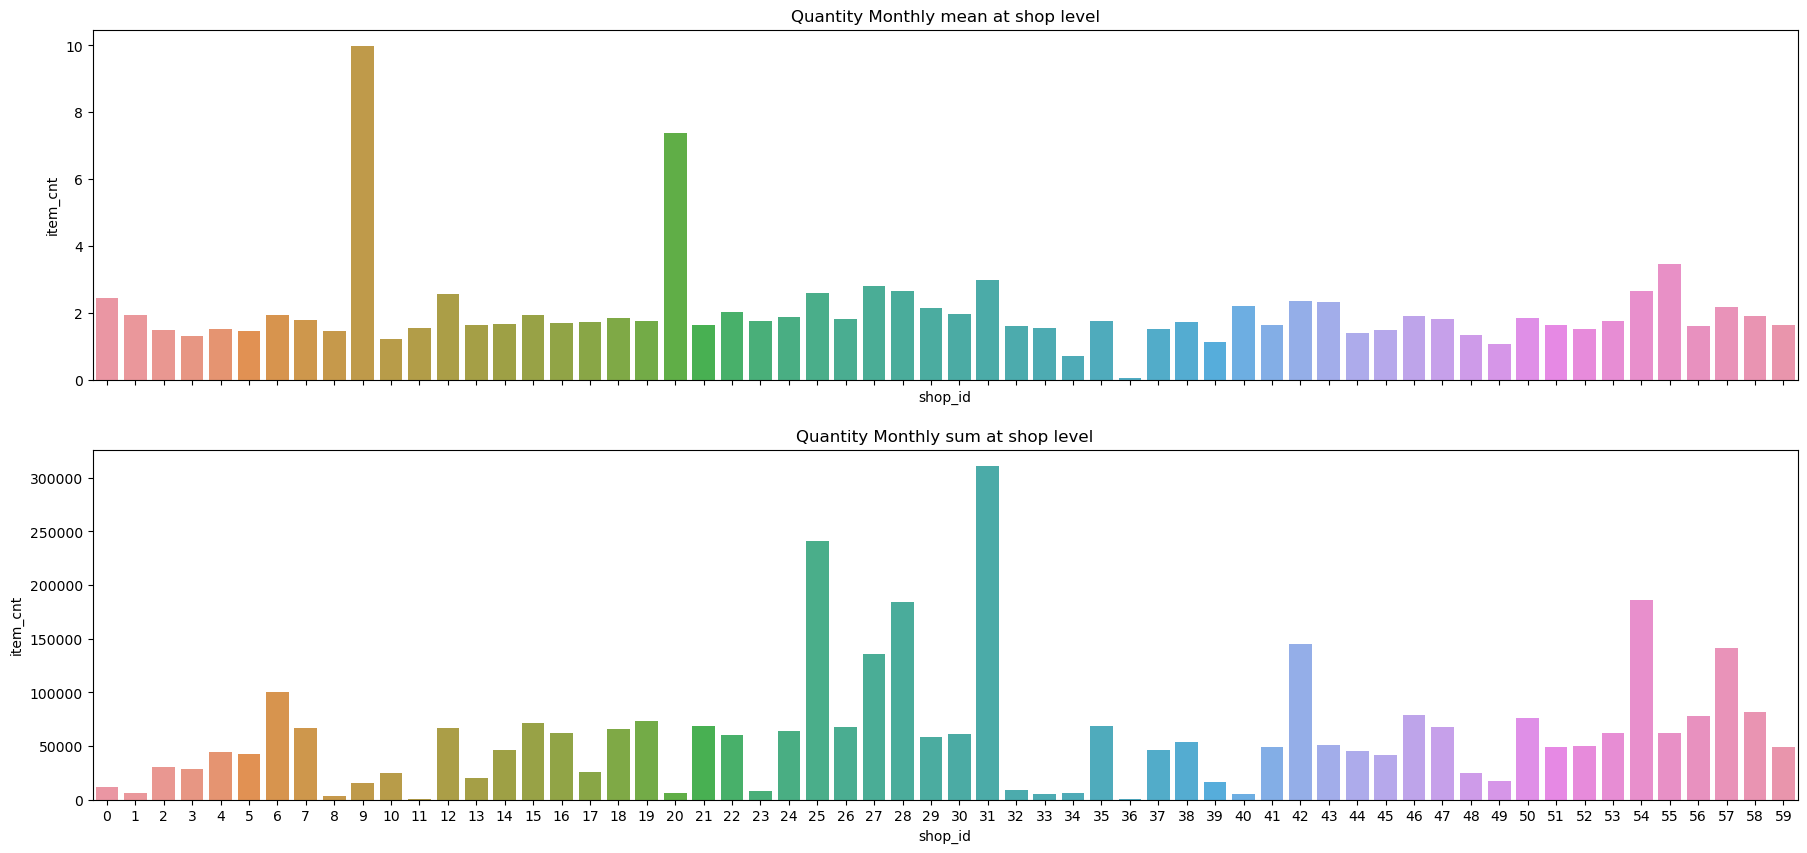

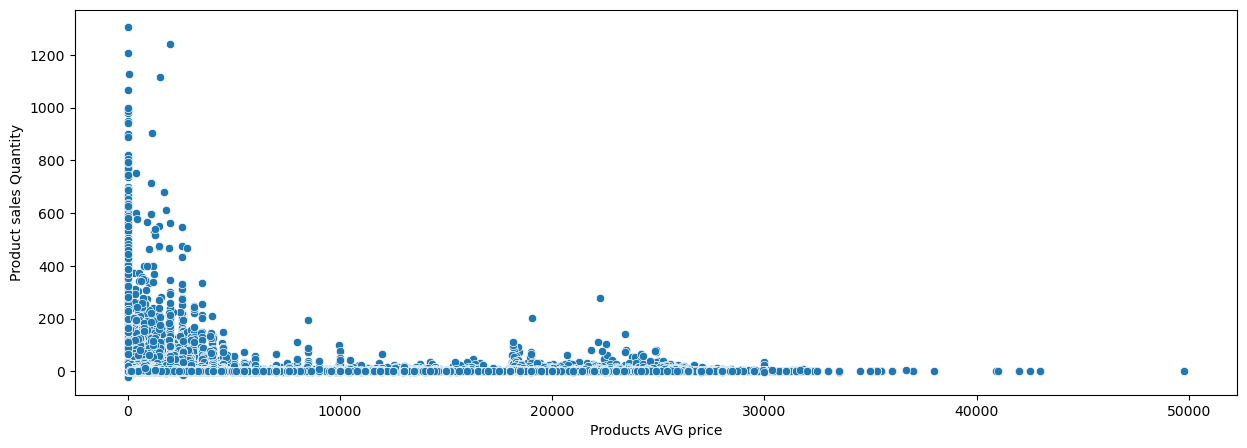

In [33]:
it_cnt = EDA_func(target_variable="item_cnt")

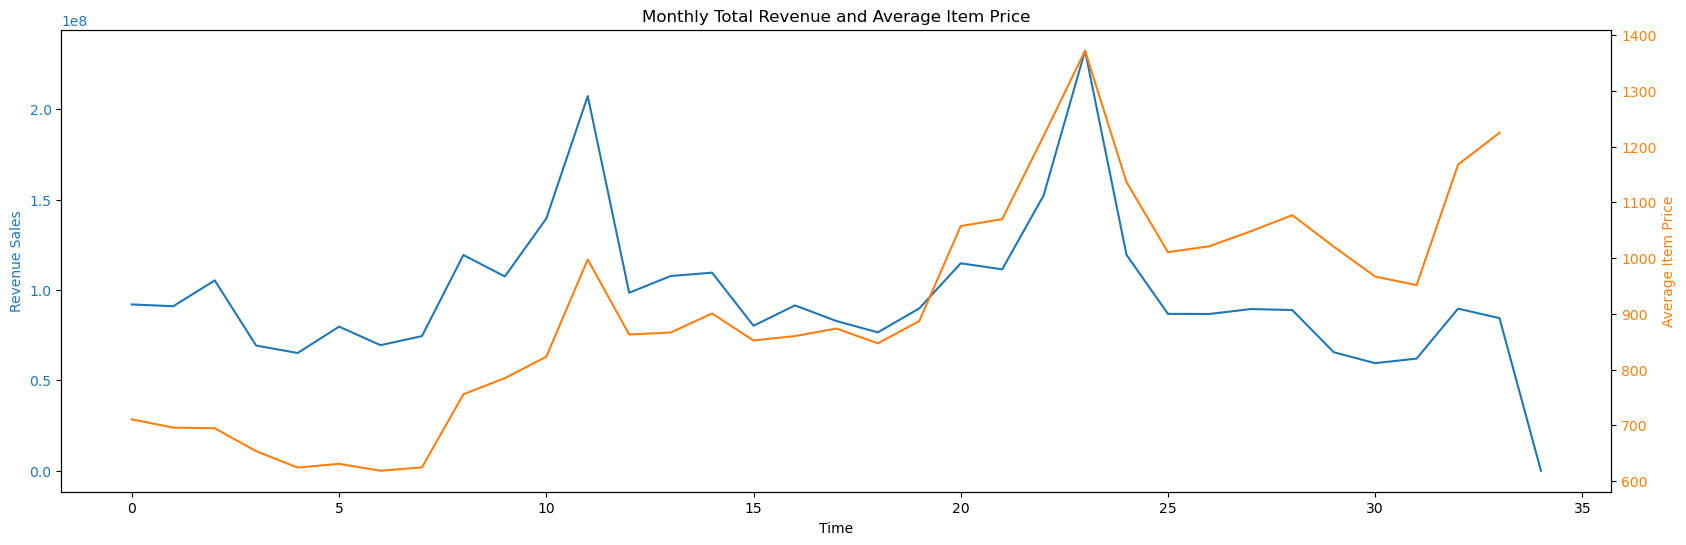

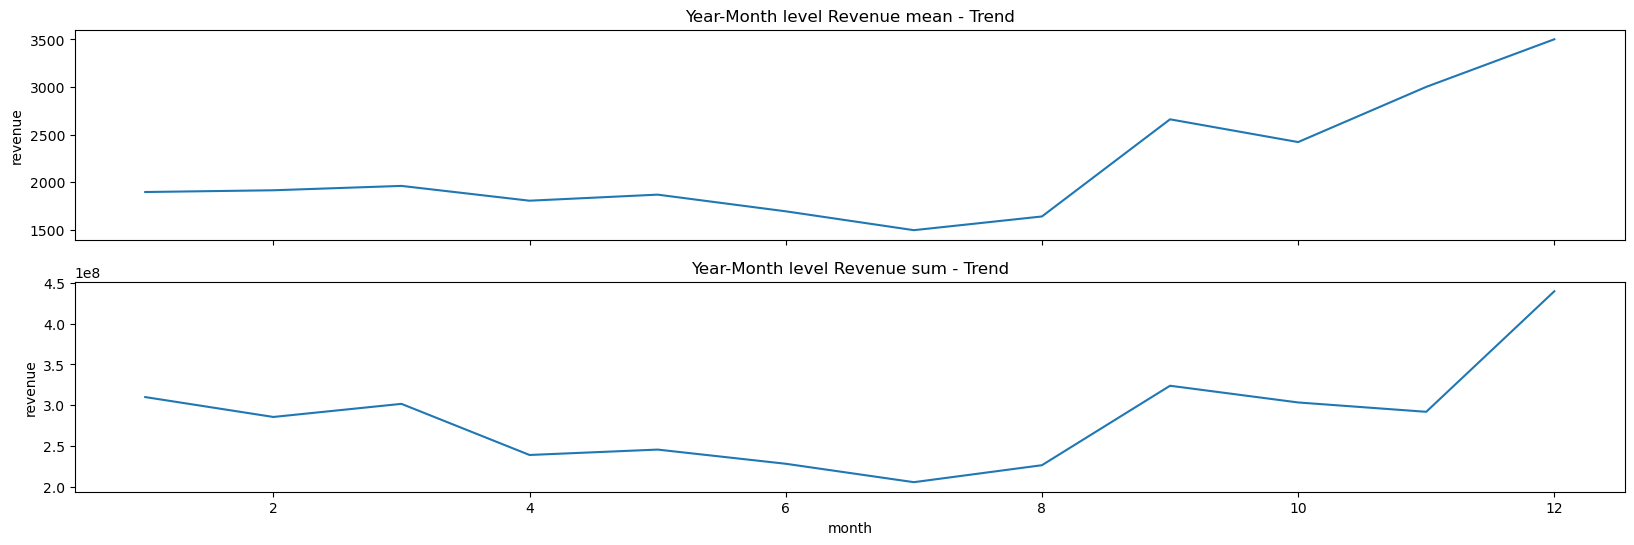

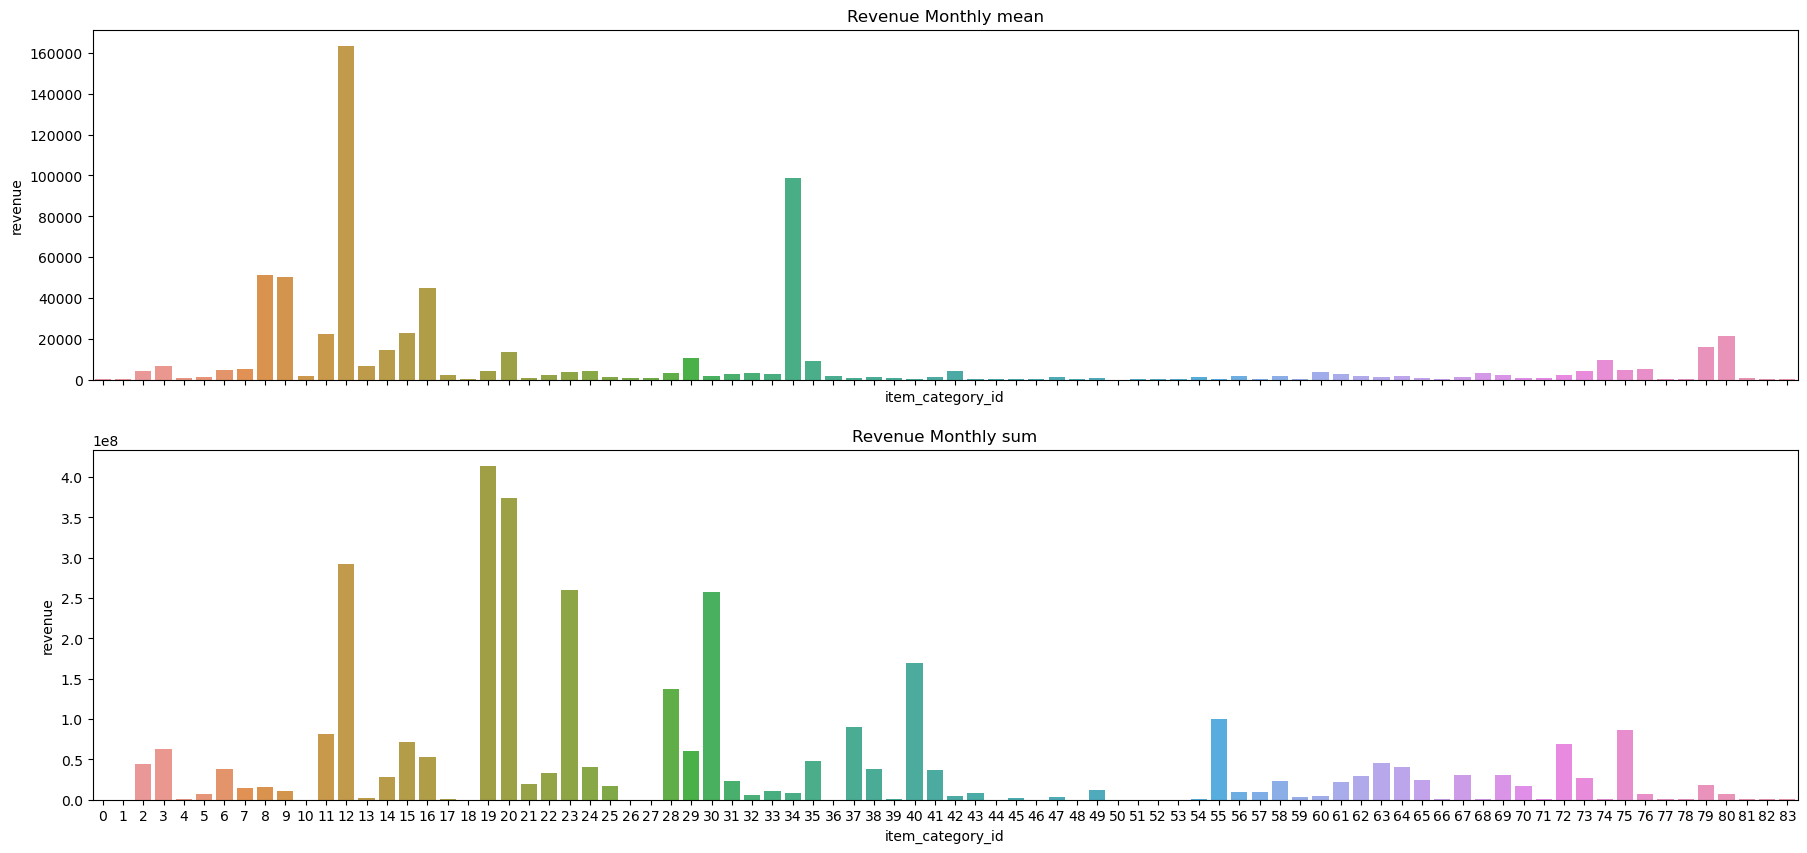

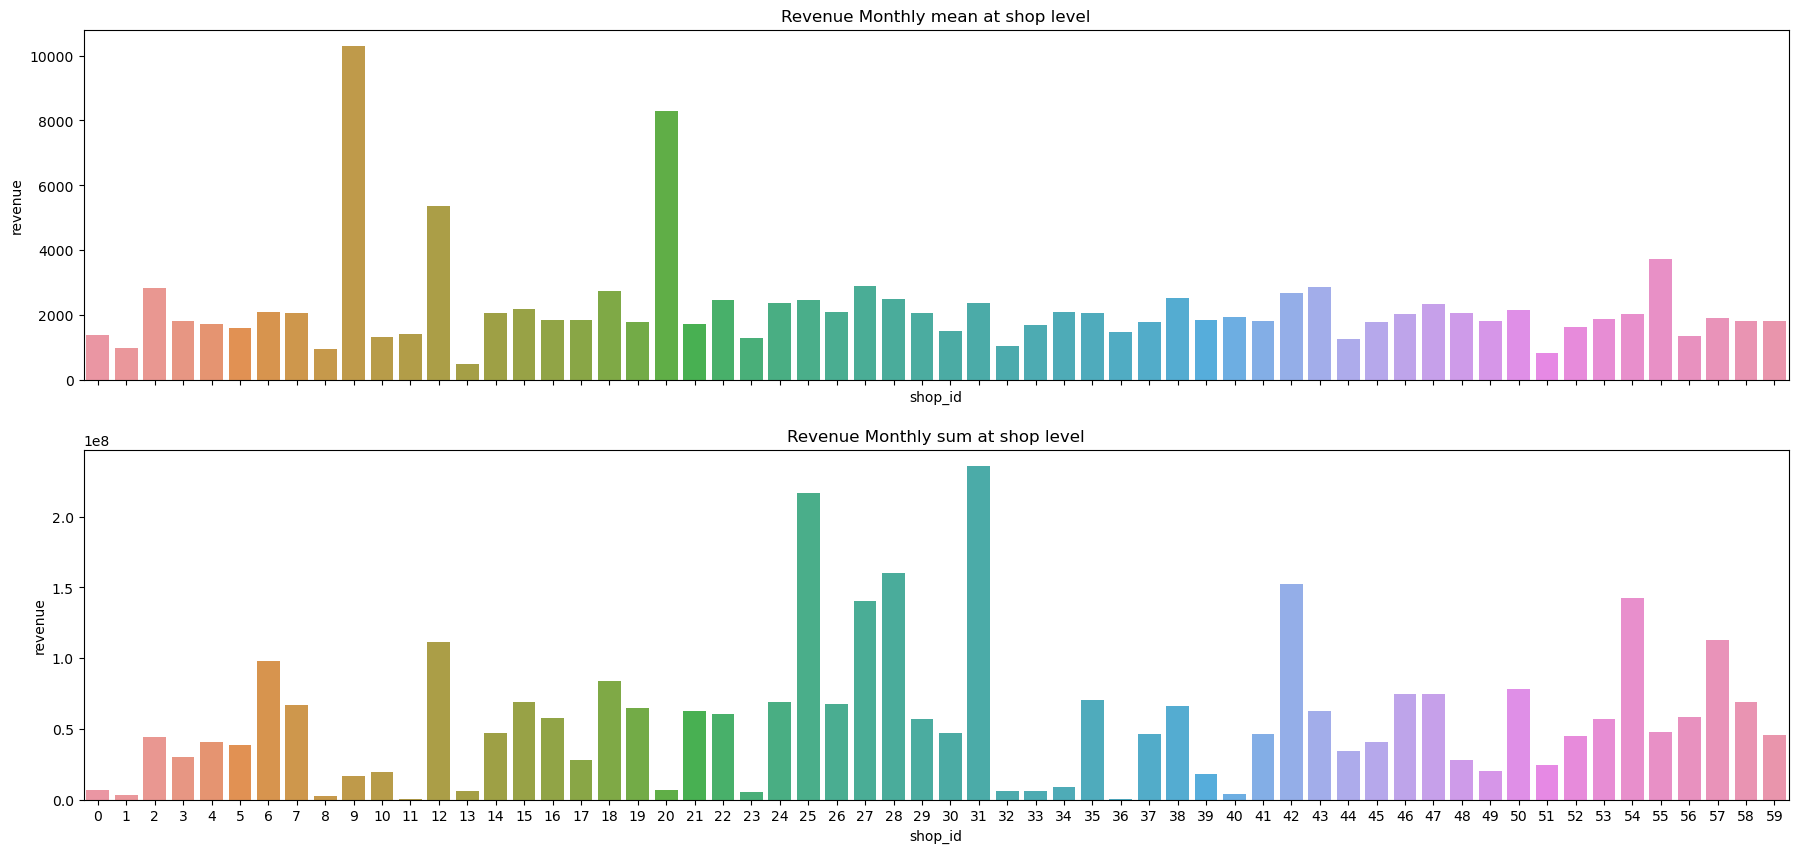

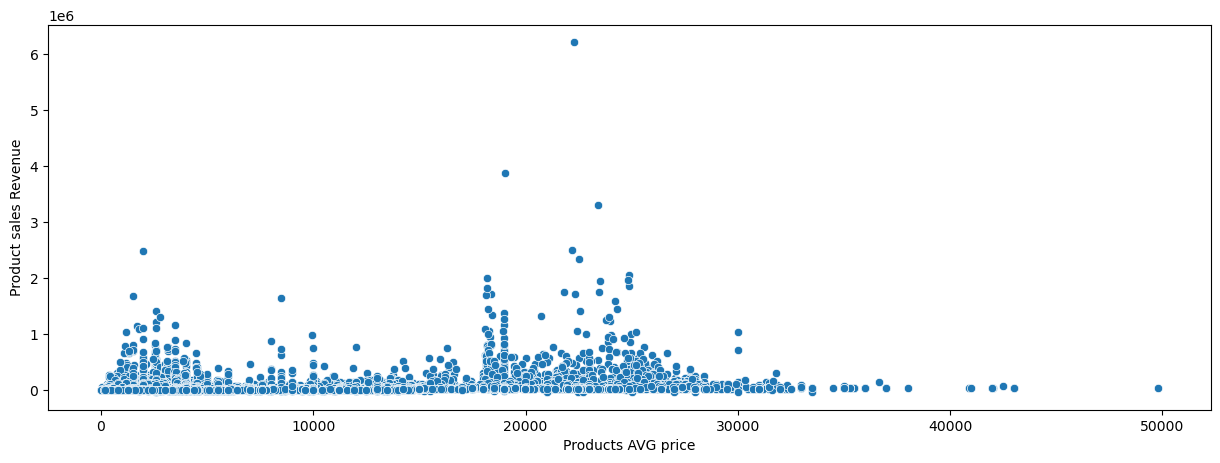

In [34]:
rev = EDA_func(target_variable="revenue")

**Key Insights:**

1. The analysis reveals a concentration of higher quantity sales for products with lower average prices. However, it's crucial to investigate whether these products generate the highest revenue.

2. The primary contributors to revenue appear to be concentrated in the price range of approximately 18,000 to 25,000.

3. Noteworthy disparities exist among shops, with some exhibiting significantly higher sales while others experience lower sales.

4. Both revenue and quantity demonstrate an upward trend over time.

5. There is an observable pattern of average prices gradually increasing over a certain period.

In [35]:
train_month_rolled.drop(["revenue"], axis = 1, inplace = True)

# Feature Engineering

We will traditionally create lead, lag features in a time series based problems + some intuitive features which might add some value to our model. But we need to keep in mind we dont create any leaky feature which led to overfit.

**Price is a key lever for the sales, we can create some features which might help the model to capture the trend to predict the future sales**
1. Creating price per item feature
2. Creating price difference from the current price - the historical min item price
3. Creating first selling month of a product and a boolean to check if a product is newly launched product at that instance
4. Creating rolling window features
5. Creating min and max price of that product
6. Creating lag features
7. Creating trend features

### 1. General Features set

In [36]:
# Adding min and max price of the item
item_price = (
    train_month_rolled.sort_values("date_block_num")
    .groupby(["item_id"], as_index=False)
    .agg({"item_price": [np.min, np.max]})
)
item_price.columns = ["item_id", "hist_min_item_price", "hist_max_item_price"]
train_month_rolled = pd.merge(train_month_rolled, item_price, on="item_id", how="left")

# Adding average price difference w.r.t the current month with min and max historic price
train_month_rolled["price_increase"] = (
    train_month_rolled["item_price"] - train_month_rolled["hist_min_item_price"]
)
train_month_rolled["price_decrease"] = (
    train_month_rolled["hist_max_item_price"] - train_month_rolled["item_price"]
)

# Adding first month of selling of a product
grp = train_month_rolled.groupby(["item_id", "shop_id"])[
    "date_block_num"
].min().reset_index().rename({"date_block_num":"first_selling_date_block"}, axis = "columns")

train_month_rolled = train_month_rolled.merge(grp, on = ['item_id', 'shop_id'], how = 'left')

# Last selling date of a producr
grp = train_month_rolled.groupby(["item_id", "shop_id"])[
    "date_block_num"
].max().reset_index().rename({"date_block_num":"last_selling_date_block"}, axis = "columns")

train_month_rolled = train_month_rolled.merge(grp, on = ['item_id', 'shop_id'], how = 'left')

# Adding a boolean if a product is a newly launched product or not
train_month_rolled["is_new_product"] = np.where(
    train_month_rolled["first_selling_date_block"] == train_month_rolled["last_selling_date_block"],1,0
)

train_month_rolled.drop(['last_selling_date_block'], axis = 1, inplace = True)

**Force filling for test data**

In [37]:
train_month_rolled.sort_values(by=['shop_id', 'item_id', 'date_block_num'], inplace=True)

# Forward fill missing values within each group defined by 'item_id'
columns_to_ffill = ["item_price", "item_cnt", "mean_item_cnt", "transactions"]
train_month_rolled[columns_to_ffill] = train_month_rolled.groupby('item_id')[columns_to_ffill].transform(lambda x: x.ffill())

### 2. Rolling window features

In [38]:
# List of functions and their corresponding names. Rolling 3 months window
functions = [lambda x: calculate_rolling_features(x).min(),
             lambda x: calculate_rolling_features(x).max(),
             lambda x: calculate_rolling_features(x).mean(),
             lambda x: calculate_rolling_features(x).std()]

func_names = ["min", "max", "mean", "std"]

# Apply rolling window functions and create new features
for i, func in enumerate(functions):
    feature_name = "item_cnt_" + func_names[i] + "_rolling"
    train_month_rolled[feature_name] = (
        train_month_rolled.sort_values("date_block_num")
        .groupby(["shop_id", "item_category_id", "item_id"])["item_cnt"]
        .apply(func)
    )

# Fill the empty std features with 0
train_month_rolled["item_cnt_min_rolling"].fillna(0, inplace=True)
train_month_rolled["item_cnt_max_rolling"].fillna(0, inplace=True)
train_month_rolled["item_cnt_mean_rolling"].fillna(0, inplace=True)
train_month_rolled["item_cnt_std_rolling"].fillna(0, inplace=True)

In [31]:
train_month_rolled

,date_block_num,shop_id,item_category_id,item_id,city_code,type_code,subcat_code,item_price,item_cnt,mean_item_cnt,transactions,first_sale_date,year,month,hist_min_item_price,hist_max_item_price,price_increase,price_decrease,first_selling_date_block,is_new_product,item_cnt_min_rolling,item_cnt_max_rolling,item_cnt_mean_rolling,item_cnt_std_rolling
64030,1,0,40,30,29,11,4,265.0,31.0,3.444444,9.0,NaN,2013,1,99.00,399.0,166.00,134.0,1,1,31.0,31.0,31.000000,0.000000
63792,1,0,37,31,29,11,1,434.0,11.0,1.571429,7.0,NaN,2013,1,147.62,699.0,286.38,265.0,1,1,11.0,11.0,11.000000,0.000000
809,0,0,40,32,29,11,4,221.0,6.0,1.500000,4.0,NaN,2013,0,70.62,349.0,150.38,128.0,0,0,6.0,6.0,6.000000,0.000000
64031,1,0,40,32,29,11,4,221.0,10.0,1.428571,7.0,NaN,2013,1,70.62,349.0,150.38,128.0,0,0,6.0,10.0,8.000000,2.828427
563,0,0,37,33,29,11,1,347.0,3.0,1.000000,3.0,NaN,2013,0,128.20,499.0,218.80,152.0,0,0,3.0,3.0,3.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1761447,34,59,54,22166,30,12,61,150.0,0.0,1.833333,6.0,9.0,2015,10,150.00,150.0,NaN,NaN,34,1,0.0,0.0,0.000000,0.000000
569786,9,59,49,22167,30,12,39,299.0,1.0,1.000000,1.0,NaN,2013,9,155.00,299.0,144.00,0.0,9,0,1.0,1.0,1.000000,0.000000
687371,11,59,49,22167,30,12,39,299.0,2.0,1.000000,2.0,NaN,2013,11,155.00,299.0,144.00,0.0,9,0,1.0,2.0,1.500000,0.707107
974834,17,59,49,22167,30,12,39,299.0,1.0,1.000000,1.0,NaN,2014,5,155.00,299.0,144.00,0.0,9,0,1.0,2.0,1.333333,0.577350


In [39]:
# Define rolling window features
def calculate_rolling_features_one_year(x, window_size=12):
    return x.rolling(window=window_size, min_periods=1)

In [40]:
# List of functions and their corresponding names. Rolling 3 months window
functions = [lambda x: calculate_rolling_features_one_year(x).mean()]

func_names = ["mean"]

# Apply rolling window functions and create new features
for i, func in enumerate(functions):
    feature_name = "item_cnt_" + func_names[i] + "_rolling_1_year"
    train_month_rolled[feature_name] = (
        train_month_rolled.sort_values("date_block_num")
        .groupby(["shop_id", "item_category_id", "item_id"])["item_cnt"]
        .apply(func)
    )

# Fill the empty std features with 0
train_month_rolled["item_cnt_mean_rolling_1_year"].fillna(0, inplace=True)

### 3. Creating lag features

**1. Creating monthly, bi-monthly, quarterly, half monthly of target feature**

In [41]:
# Define the lag values you want (e.g., lag 1, lag 2)
lags = [1, 2, 3]  

# Features to create lag columns for
lag_features = ["item_price", "item_cnt", "mean_item_cnt", "transactions"]

# Iterate through each lag and create lag columns for each feature
for lag in lags:
    for feature in lag_features:
        new_col_name = f"{feature}_lag_{lag}"
        train_month_rolled[new_col_name] = train_month_rolled.groupby(['item_id', 'shop_id'])[feature].shift(lag)

In [42]:
train_month_rolled[train_month_rolled['is_new_product']==0]

,date_block_num,shop_id,item_category_id,item_id,city_code,type_code,subcat_code,item_price,item_cnt,mean_item_cnt,transactions,first_sale_date,year,month,hist_min_item_price,hist_max_item_price,price_increase,price_decrease,first_selling_date_block,is_new_product,item_cnt_min_rolling,item_cnt_max_rolling,item_cnt_mean_rolling,item_cnt_std_rolling,item_cnt_mean_rolling_1_year,item_price_lag_1,item_cnt_lag_1,mean_item_cnt_lag_1,transactions_lag_1,item_price_lag_2,item_cnt_lag_2,mean_item_cnt_lag_2,transactions_lag_2,item_price_lag_3,item_cnt_lag_3,mean_item_cnt_lag_3,transactions_lag_3
809,0,0,40,32,29,11,4,221.0,6.0,1.500000,4.0,NaN,2013,1,70.62,349.0,150.38,128.0,0,0,6.0,6.0,6.000000,0.000000,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64031,1,0,40,32,29,11,4,221.0,10.0,1.428571,7.0,NaN,2013,2,70.62,349.0,150.38,128.0,0,0,6.0,10.0,8.000000,2.828427,8.000000,221.0,6.0,1.5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
563,0,0,37,33,29,11,1,347.0,3.0,1.000000,3.0,NaN,2013,1,128.20,499.0,218.80,152.0,0,0,3.0,3.0,3.000000,0.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63793,1,0,37,33,29,11,1,347.0,3.0,1.000000,3.0,NaN,2013,2,128.20,499.0,218.80,152.0,0,0,3.0,3.0,3.000000,0.000000,3.000000,347.0,3.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
810,0,0,40,35,29,11,4,247.0,1.0,1.000000,1.0,NaN,2013,1,148.00,399.0,99.00,152.0,0,0,1.0,1.0,1.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758361,34,59,37,22164,30,11,1,699.0,0.0,1.000000,1.0,25.0,2015,11,379.62,749.0,NaN,NaN,25,0,0.0,2.0,1.000000,1.000000,1.200000,699.0,1.0,1.0,1.0,699.0,2.0,1.0,2.0,749.0,1.0,1.0,1.0
569786,9,59,49,22167,30,12,39,299.0,1.0,1.000000,1.0,NaN,2013,10,155.00,299.0,144.00,0.0,9,0,1.0,1.0,1.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
687371,11,59,49,22167,30,12,39,299.0,2.0,1.000000,2.0,NaN,2013,12,155.00,299.0,144.00,0.0,9,0,1.0,2.0,1.500000,0.707107,1.500000,299.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
974834,17,59,49,22167,30,12,39,299.0,1.0,1.000000,1.0,NaN,2014,6,155.00,299.0,144.00,0.0,9,0,1.0,2.0,1.333333,0.577350,1.333333,299.0,2.0,1.0,2.0,299.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN


In [43]:
train_month_rolled[(train_month_rolled['item_id']==22167) & (train_month_rolled['shop_id']==59)]

,date_block_num,shop_id,item_category_id,item_id,city_code,type_code,subcat_code,item_price,item_cnt,mean_item_cnt,transactions,first_sale_date,year,month,hist_min_item_price,hist_max_item_price,price_increase,price_decrease,first_selling_date_block,is_new_product,item_cnt_min_rolling,item_cnt_max_rolling,item_cnt_mean_rolling,item_cnt_std_rolling,item_cnt_mean_rolling_1_year,item_price_lag_1,item_cnt_lag_1,mean_item_cnt_lag_1,transactions_lag_1,item_price_lag_2,item_cnt_lag_2,mean_item_cnt_lag_2,transactions_lag_2,item_price_lag_3,item_cnt_lag_3,mean_item_cnt_lag_3,transactions_lag_3
569786,9,59,49,22167,30,12,39,299.0,1.0,1.0,1.0,NaN,2013,10,155.0,299.0,144.0,0.0,9,0,1.0,1.0,1.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
687371,11,59,49,22167,30,12,39,299.0,2.0,1.0,2.0,NaN,2013,12,155.0,299.0,144.0,0.0,9,0,1.0,2.0,1.500000,0.707107,1.500000,299.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
974834,17,59,49,22167,30,12,39,299.0,1.0,1.0,1.0,NaN,2014,6,155.0,299.0,144.0,0.0,9,0,1.0,2.0,1.333333,0.577350,1.333333,299.0,2.0,1.0,2.0,299.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
1757496,34,59,49,22167,30,12,39,299.0,0.0,1.0,1.0,8.0,2015,11,155.0,299.0,NaN,NaN,9,0,0.0,2.0,1.000000,1.000000,1.000000,299.0,1.0,1.0,1.0,299.0,2.0,1.0,2.0,299.0,1.0,1.0,1.0


**2. Creating mean item quanity per item category per month**

In [44]:
grp = train_month_rolled.groupby(["date_block_num", "item_category_id"]).agg(
    {"item_cnt": ["mean"]}
)
grp.columns = ["date_cat_avg_item_cnt"]
grp.reset_index(inplace=True)

train_month_rolled = pd.merge(
    train_month_rolled, grp, on=["date_block_num", "item_category_id"], how="left"
)
train_month_rolled["date_cat_avg_item_cnt"] = train_month_rolled["date_cat_avg_item_cnt"].astype(
    np.float16
)

**3. Creating mean item quantity per shop id per month**

In [45]:
grp = train_month_rolled.groupby(["date_block_num", "shop_id"]).agg({"item_cnt": ["mean"]})
grp.columns = ["date_shop_cnt"]
grp.reset_index(inplace=True)

train_month_rolled = pd.merge(
    train_month_rolled, grp, on=["date_block_num", "shop_id"], how="left"
)
train_month_rolled["date_shop_cnt"] = train_month_rolled["date_shop_cnt"].astype(np.float16)

**4.Creating mean item quantity per shop and item category id**

In [46]:
grp = train_month_rolled.groupby(["date_block_num", "shop_id", "item_category_id"]).agg(
    {"item_cnt": ["mean"]}
)
grp.columns = ["date_shop_cat_avg_item_cnt"]
grp.reset_index(inplace=True)

train_month_rolled = pd.merge(
    train_month_rolled, grp, on=["date_block_num", "shop_id", "item_category_id"], how="left"
)
train_month_rolled["date_shop_cat_avg_item_cnt"] = train_month_rolled[
    "date_shop_cat_avg_item_cnt"
].astype(np.float16)

**5.Creating mean item quantity per shop and item type code**

In [47]:
grp = train_month_rolled.groupby(["date_block_num", "shop_id", "type_code"]).agg(
    {"item_cnt": ["mean"]}
)
grp.columns = ["date_shop_type_avg_item_cnt"]
grp.reset_index(inplace=True)

train_month_rolled = pd.merge(
    train_month_rolled, grp, on=["date_block_num", "shop_id", "type_code"], how="left"
)
train_month_rolled["date_shop_type_avg_item_cnt"] = train_month_rolled[
    "date_shop_type_avg_item_cnt"
].astype(np.float16)

**6.Creating mean per shop id and subcategory code**

In [48]:
grp = train_month_rolled.groupby(["date_block_num", "shop_id", "subcat_code"]).agg(
    {"item_cnt": ["mean"]}
)
grp.columns = ["date_shop_subcat_avg_item_cnt"]
grp.reset_index(inplace=True)

train_month_rolled = pd.merge(
    train_month_rolled, grp, on=["date_block_num", "shop_id", "subcat_code"], how="left"
)
train_month_rolled["date_shop_subcat_avg_item_cnt"] = train_month_rolled[
    "date_shop_subcat_avg_item_cnt"
].astype(np.float16)

**7.Creating mean per city_code level**

In [49]:
grp = train_month_rolled.groupby(["date_block_num", "city_code"]).agg({"item_cnt": ["mean"]})
grp.columns = ["date_city_avg_item_cnt"]
grp.reset_index(inplace=True)

train_month_rolled = pd.merge(
    train_month_rolled, grp, on=["date_block_num", "city_code"], how="left"
)
train_month_rolled["date_city_avg_item_cnt"] = train_month_rolled[
    "date_city_avg_item_cnt"
].astype(np.float16)

**8. Creating mean per item and city code**

In [50]:
# 9.====Creating lag features at city and item code level====
grp = train_month_rolled.groupby(["date_block_num", "item_id", "city_code"]).agg(
    {"item_cnt": ["mean"]}
)
grp.columns = ["date_item_city_avg_item_cnt"]
grp.reset_index(inplace=True)

train_month_rolled = pd.merge(
    train_month_rolled, grp, on=["date_block_num", "item_id", "city_code"], how="left"
)
train_month_rolled["date_item_city_avg_item_cnt"] = train_month_rolled[
    "date_item_city_avg_item_cnt"
].astype(np.float16)

**9.Creating mean per item type code and month level**

In [51]:
grp = train_month_rolled.groupby(["date_block_num", "type_code"]).agg({"item_cnt": ["mean"]})
grp.columns = ["date_type_avg_item_cnt"]
grp.reset_index(inplace=True)

train_month_rolled = pd.merge(
    train_month_rolled, grp, on=["date_block_num", "type_code"], how="left"
)
train_month_rolled["date_type_avg_item_cnt"] = train_month_rolled[
    "date_type_avg_item_cnt"
].astype(np.float16)

**10. Creating mean per subcategory code per month level**

In [52]:
grp = train_month_rolled.groupby(["date_block_num", "subcat_code"]).agg(
    {"item_cnt": ["mean"]}
)
grp.columns = ["date_subtype_avg_item_cnt"]
grp.reset_index(inplace=True)

train_month_rolled = pd.merge(
    train_month_rolled, grp, on=["date_block_num", "subcat_code"], how="left"
)
train_month_rolled["date_subtype_avg_item_cnt"] = train_month_rolled[
    "date_subtype_avg_item_cnt"
].astype(np.float16)

In [53]:
train_month_rolled[train_month_rolled['item_id']==31]

,date_block_num,shop_id,item_category_id,item_id,city_code,type_code,subcat_code,item_price,item_cnt,mean_item_cnt,transactions,first_sale_date,year,month,hist_min_item_price,hist_max_item_price,price_increase,price_decrease,first_selling_date_block,is_new_product,item_cnt_min_rolling,item_cnt_max_rolling,item_cnt_mean_rolling,item_cnt_std_rolling,item_cnt_mean_rolling_1_year,item_price_lag_1,item_cnt_lag_1,mean_item_cnt_lag_1,transactions_lag_1,item_price_lag_2,item_cnt_lag_2,mean_item_cnt_lag_2,transactions_lag_2,item_price_lag_3,item_cnt_lag_3,mean_item_cnt_lag_3,transactions_lag_3,date_cat_avg_item_cnt,date_shop_cnt,date_shop_cat_avg_item_cnt,date_shop_type_avg_item_cnt,date_shop_subcat_avg_item_cnt,date_city_avg_item_cnt,date_item_city_avg_item_cnt,date_type_avg_item_cnt,date_subtype_avg_item_cnt
1,1,0,37,31,29,11,1,434.000000,11.0,1.571429,7.0,NaN,2013,2,147.62,699.0,286.380000,265.000000,1,1,11.0,11.0,11.000000,0.000000,11.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.619141,2.515625,1.649414,2.425781,1.613281,2.269531,7.5,1.856445,1.576172
4824,1,1,37,31,29,11,1,434.000000,4.0,1.333333,3.0,NaN,2013,2,147.62,699.0,286.380000,265.000000,1,1,4.0,4.0,4.000000,0.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.619141,1.925781,1.089844,1.582031,1.084961,2.269531,7.5,1.856445,1.576172
8110,1,2,37,31,0,11,1,699.000000,4.0,1.000000,4.0,NaN,2013,2,147.62,699.0,551.380000,0.000000,1,0,4.0,4.0,4.000000,0.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.619141,1.505859,1.400391,1.147461,1.307617,1.505859,4.0,1.856445,1.576172
8111,2,2,37,31,0,11,1,698.500000,1.0,1.000000,1.0,NaN,2013,3,147.62,699.0,550.880000,0.500000,1,0,1.0,4.0,2.500000,2.121320,2.500000,699.000000,4.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.578125,1.759766,1.071289,1.069336,1.099609,1.759766,1.0,1.908203,1.554688
8112,3,2,37,31,0,11,1,699.000000,1.0,1.000000,1.0,NaN,2013,4,147.62,699.0,551.380000,0.000000,1,0,1.0,4.0,2.000000,1.732051,2.000000,698.500000,1.0,1.0,1.0,699.000000,4.0,1.0,4.0,NaN,NaN,NaN,NaN,1.594727,1.450195,1.133789,1.253906,1.230469,1.450195,1.0,1.804688,1.636719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1793148,9,59,37,31,30,11,1,599.000000,2.0,1.000000,2.0,NaN,2013,10,147.62,699.0,451.380000,100.000000,1,0,1.0,2.0,1.333333,0.577350,2.500000,699.000000,1.0,1.0,1.0,699.000000,1.0,1.0,1.0,699.00,2.0,1.0,2.0,1.506836,2.064453,1.236328,1.497070,1.248047,2.064453,2.0,1.872070,1.504883
1793149,23,59,37,31,30,11,1,415.970000,1.0,1.000000,1.0,NaN,2014,12,147.62,699.0,268.350000,283.030000,1,0,1.0,2.0,1.333333,0.577350,2.285714,599.000000,2.0,1.0,2.0,699.000000,1.0,1.0,1.0,699.00,1.0,1.0,1.0,1.845703,2.216797,1.388672,1.406250,1.355469,2.216797,1.0,1.978516,1.799805
1793150,31,59,37,31,30,11,1,215.666667,3.0,1.000000,3.0,NaN,2015,8,147.62,699.0,68.046667,483.333333,1,0,1.0,3.0,2.000000,1.000000,2.375000,415.970000,1.0,1.0,1.0,599.000000,2.0,1.0,2.0,699.00,1.0,1.0,1.0,1.506836,2.046875,1.457031,1.238281,1.333008,2.046875,3.0,1.541016,1.437500
1793151,33,59,37,31,30,11,1,399.000000,1.0,1.000000,1.0,NaN,2015,10,147.62,699.0,251.380000,300.000000,1,0,1.0,3.0,1.666667,1.154701,2.222222,215.666667,3.0,1.0,3.0,415.970000,1.0,1.0,1.0,599.00,2.0,1.0,2.0,1.701172,1.580078,1.050781,1.197266,1.083008,1.580078,1.0,1.617188,1.636719


In [54]:
# Applying lag function
lag_on_list = [
    "date_cat_avg_item_cnt",
    "date_shop_cnt",
    "date_shop_cat_avg_item_cnt",
    "date_shop_type_avg_item_cnt",
    "date_shop_subcat_avg_item_cnt",
    "date_city_avg_item_cnt",
    "date_item_city_avg_item_cnt",
    "date_type_avg_item_cnt",
    "date_subtype_avg_item_cnt"
]

# Define the lag values you want (e.g., lag 1, lag 2)
lags = [1, 2, 3]  

# Features to create lag columns for
lag_features = lag_on_list

# Iterate through each lag and create lag columns for each feature
for lag in lags:
    for feature in lag_features:
        new_col_name = f"{feature}_lag_{lag}"
        train_month_rolled[new_col_name] = train_month_rolled.groupby(['item_id', 'shop_id'])[feature].shift(lag)

**Trend Features**
Lets look at the closest not nullable price, to compare it with the avg price. If an item costs less than in the past - its is a positive thend, otherwise - negative. The more difference between closest price and avg price - the more trend value.

**Past three month revenue and qty average**

In [55]:
# Creating last 3 month average of sales
train_month_rolled["quarter_mean_item_cnt"] = train_month_rolled[
    ["item_cnt_lag_1", "item_cnt_lag_2", "item_cnt_lag_3"]
].mean(skipna=True, axis=1)

**Additional trend variables**

In [56]:
train_month_rolled['item_cnt_trend'] = train_month_rolled['item_cnt_lag_1'] - train_month_rolled['item_cnt_lag_2']
train_month_rolled['item_price_trend'] = train_month_rolled['item_price_lag_1'] - train_month_rolled['item_price_lag_2']

In [60]:
# Saving the data
train_month_rolled.to_pickle("train_month_rolled.pkl")

del grp
del items
del shops
#del cats
del train
gc.collect()

0

# Modelling Data Prep :

In [61]:
# Specify the path to your .pkl file
file_path = 'train_month_rolled.pkl'

# Open the file in binary mode
with open(file_path, 'rb') as file:
    # Load the object from the file
    train_month_rolled = pickle.load(file)

In [62]:
train_month_rolled.head()

,date_block_num,shop_id,item_category_id,item_id,city_code,type_code,subcat_code,item_price,item_cnt,mean_item_cnt,transactions,first_sale_date,year,month,hist_min_item_price,hist_max_item_price,price_increase,price_decrease,first_selling_date_block,is_new_product,item_cnt_min_rolling,item_cnt_max_rolling,item_cnt_mean_rolling,item_cnt_std_rolling,item_cnt_mean_rolling_1_year,item_price_lag_1,item_cnt_lag_1,mean_item_cnt_lag_1,transactions_lag_1,item_price_lag_2,item_cnt_lag_2,mean_item_cnt_lag_2,transactions_lag_2,item_price_lag_3,item_cnt_lag_3,mean_item_cnt_lag_3,transactions_lag_3,date_cat_avg_item_cnt,date_shop_cnt,date_shop_cat_avg_item_cnt,date_shop_type_avg_item_cnt,date_shop_subcat_avg_item_cnt,date_city_avg_item_cnt,date_item_city_avg_item_cnt,date_type_avg_item_cnt,date_subtype_avg_item_cnt,date_cat_avg_item_cnt_lag_1,date_shop_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subcat_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,date_cat_avg_item_cnt_lag_2,date_shop_cnt_lag_2,date_shop_cat_avg_item_cnt_lag_2,date_shop_type_avg_item_cnt_lag_2,date_shop_subcat_avg_item_cnt_lag_2,date_city_avg_item_cnt_lag_2,date_item_city_avg_item_cnt_lag_2,date_type_avg_item_cnt_lag_2,date_subtype_avg_item_cnt_lag_2,date_cat_avg_item_cnt_lag_3,date_shop_cnt_lag_3,date_shop_cat_avg_item_cnt_lag_3,date_shop_type_avg_item_cnt_lag_3,date_shop_subcat_avg_item_cnt_lag_3,date_city_avg_item_cnt_lag_3,date_item_city_avg_item_cnt_lag_3,date_type_avg_item_cnt_lag_3,date_subtype_avg_item_cnt_lag_3,quarter_mean_item_cnt,item_cnt_trend,item_price_trend
0,1,0,40,30,29,11,4,265.0,31.0,3.444444,9.0,NaN,2013,2,99.00,399.0,166.00,134.0,1,1,31.0,31.0,31.0,0.000000,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.971680,2.515625,2.753906,2.425781,2.753906,2.269531,20.5,1.856445,1.971680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,37,31,29,11,1,434.0,11.0,1.571429,7.0,NaN,2013,2,147.62,699.0,286.38,265.0,1,1,11.0,11.0,11.0,0.000000,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.619141,2.515625,1.649414,2.425781,1.613281,2.269531,7.5,1.856445,1.576172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,40,32,29,11,4,221.0,6.0,1.500000,4.0,NaN,2013,1,70.62,349.0,150.38,128.0,0,0,6.0,6.0,6.0,0.000000,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.865234,2.337891,2.207031,1.989258,2.207031,2.173828,6.5,1.741211,1.865234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0,40,32,29,11,4,221.0,10.0,1.428571,7.0,NaN,2013,2,70.62,349.0,150.38,128.0,0,0,6.0,10.0,8.0,2.828427,8.0,221.0,6.0,1.5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.971680,2.515625,2.753906,2.425781,2.753906,2.269531,6.5,1.856445,1.971680,1.865234,2.337891,2.207031,1.989258,2.207031,2.173828,6.5,1.741211,1.865234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN
4,0,0,37,33,29,11,1,347.0,3.0,1.000000,3.0,NaN,2013,1,128.20,499.0,218.80,152.0,0,0,3.0,3.0,3.0,0.000000,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.448242,2.337891,1.445312,1.989258,1.418945,2.173828,3.0,1.741211,1.429688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
train_month_rolled.columns

Index(['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'city_code',
       'type_code', 'subcat_code', 'item_price', 'item_cnt', 'mean_item_cnt',
       'transactions', 'first_sale_date', 'year', 'month',
       'hist_min_item_price', 'hist_max_item_price', 'price_increase',
       'price_decrease', 'first_selling_date_block', 'is_new_product',
       'item_cnt_min_rolling', 'item_cnt_max_rolling', 'item_cnt_mean_rolling',
       'item_cnt_std_rolling', 'item_cnt_mean_rolling_1_year',
       'item_price_lag_1', 'item_cnt_lag_1', 'mean_item_cnt_lag_1',
       'transactions_lag_1', 'item_price_lag_2', 'item_cnt_lag_2',
       'mean_item_cnt_lag_2', 'transactions_lag_2', 'item_price_lag_3',
       'item_cnt_lag_3', 'mean_item_cnt_lag_3', 'transactions_lag_3',
       'date_cat_avg_item_cnt', 'date_shop_cnt', 'date_shop_cat_avg_item_cnt',
       'date_shop_type_avg_item_cnt', 'date_shop_subcat_avg_item_cnt',
       'date_city_avg_item_cnt', 'date_item_city_avg_item_cnt',
       

In [64]:
lag_feat = ['item_price_lag_1', 'item_price_lag_2', 'item_price_lag_3',
       'item_cnt_lag_1', 'item_cnt_lag_2', 'item_cnt_lag_3',
       'mean_item_cnt_lag_1', 'mean_item_cnt_lag_2', 'mean_item_cnt_lag_3',
       'transactions_lag_1', 'transactions_lag_2', 'transactions_lag_3',
       'date_cat_avg_item_cnt_lag_1', 'date_cat_avg_item_cnt_lag_2',
       'date_cat_avg_item_cnt_lag_3', 'date_shop_cnt_lag_1',
       'date_shop_cnt_lag_2', 'date_shop_cnt_lag_3',
       'date_shop_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_2',
       'date_shop_cat_avg_item_cnt_lag_3', 'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_2',
       'date_shop_type_avg_item_cnt_lag_3',
       'date_shop_subcat_avg_item_cnt_lag_1',
       'date_shop_subcat_avg_item_cnt_lag_2',
       'date_shop_subcat_avg_item_cnt_lag_3', 'date_city_avg_item_cnt_lag_1',
       'date_city_avg_item_cnt_lag_2', 'date_city_avg_item_cnt_lag_3',
       'date_item_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_2',
       'date_item_city_avg_item_cnt_lag_3', 'date_type_avg_item_cnt_lag_1',
       'date_type_avg_item_cnt_lag_2', 'date_type_avg_item_cnt_lag_3',
       'date_subtype_avg_item_cnt_lag_1', 'date_subtype_avg_item_cnt_lag_2',
       'date_subtype_avg_item_cnt_lag_3']

l = [x.split("_lag")[0] for x in lag_feat]
l = list(set(l))


max_corr_feat = []
for i in l:
    target_feature = 'item_cnt'
    
    fil_feat = [x for x in lag_feat if i in x]
    
    # Calculate correlation matrix for the group
    correlation_matrix = train_month_rolled[fil_feat + [target_feature]].corr()
    
    # Get the lag feature with maximum correlation for 'item_cnt'
    max_corr_lag_feature = correlation_matrix[target_feature].nlargest(2).index[1]
    
    max_corr_feat.append(max_corr_lag_feature)

In [65]:
max_corr_feat = list(set(max_corr_feat))
max_corr_feat

['date_type_avg_item_cnt_lag_1',
 'transactions_lag_1',
 'date_shop_cat_avg_item_cnt_lag_1',
 'mean_item_cnt_lag_1',
 'date_city_avg_item_cnt_lag_1',
 'date_cat_avg_item_cnt_lag_1',
 'item_price_lag_1',
 'date_shop_cnt_lag_1',
 'date_shop_type_avg_item_cnt_lag_1',
 'date_shop_subcat_avg_item_cnt_lag_1',
 'date_item_city_avg_item_cnt_lag_1',
 'date_subtype_avg_item_cnt_lag_1']

In [69]:
main_feat = [
    "date_block_num",
    "shop_id",
    "item_category_id",
    "item_id",
    "city_code",
    "type_code",
    "subcat_code",
    "item_price",
    "item_cnt",
    "mean_item_cnt",
    "transactions",
    "first_sale_date",
    "year",
    "month",
    "hist_min_item_price",
    "hist_max_item_price",
    "price_increase",
    "price_decrease",
    "first_selling_date_block",
    "is_new_product",
    "item_cnt_min_rolling",
    "item_cnt_max_rolling",
    "item_cnt_mean_rolling",
    "item_cnt_mean_rolling_1_year",
    "item_cnt_std_rolling",
    "quarter_mean_item_cnt",
    "item_cnt_trend",
    "item_price_trend",
]

final_feat = main_feat + max_corr_feat

In [70]:
train_month_rolled = train_month_rolled[final_feat]

In [71]:
# Clipping the data first as discussed
train_month_rolled["item_cnt"] = train_month_rolled["item_cnt"].clip(0, 20) # This is given on Kaggle

In [72]:
train_month_rolled.fillna(0, inplace = True)

In [73]:
train_month_rolled['shop_item_id'] = train_month_rolled['shop_id'].astype(str) + "_" + train_month_rolled['item_id'].astype(str)
# cat_cols = [
#     "shop_id",
#     "item_id",
#     "item_category_id",
#     "city_code",
#     "type_code",
#     "subcat_code",
#     "month",
# ]

In [74]:
train_month_rolled.columns

cat_cols = [
    "shop_id",
    "item_id",
    "item_category_id",
    "city_code",
    "type_code",
    "subcat_code",
    "shop_item_id"
]

In [75]:
# Define a smoothing parameter (to avoid division by zero)
smoothing = 0.001

# Create an empty dictionary to store the mappings
mapping_dict = {}

# Define a function for target encoding with noise
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))

cat_cols_encode = [
    "city_code",
    "type_code",
    "subcat_code",
    "shop_item_id"
]

# Iterate through each categorical column
for col in cat_cols_encode:
    # Calculate the mean target for each category
    mean_encoded = train_month_rolled.groupby(col)['item_cnt'].mean()

    # Apply target encoding with noise to the original DataFrame
    train_month_rolled[col + '_encoded'] = train_month_rolled[col].map(mean_encoded)

    # Add noise to the target encoding
    train_month_rolled[col + '_encoded'] = add_noise(train_month_rolled[col + '_encoded'], smoothing)

    # Store the mapping in the dictionary
    mapping_dict[col] = mean_encoded.to_dict()

    # Drop the original categorical column (if needed)
    # train_data.drop(col, axis=1, inplace=True)

# Display the modified DataFrame
print(train_month_rolled.head())

# Display the mapping dictionary
print(mapping_dict)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [76]:
train_month_rolled_cp = train_month_rolled.copy()

In [77]:
train_month_rolled_cp.columns

Index(['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'city_code',
       'type_code', 'subcat_code', 'item_price', 'item_cnt', 'mean_item_cnt',
       'transactions', 'first_sale_date', 'year', 'month',
       'hist_min_item_price', 'hist_max_item_price', 'price_increase',
       'price_decrease', 'first_selling_date_block', 'is_new_product',
       'item_cnt_min_rolling', 'item_cnt_max_rolling', 'item_cnt_mean_rolling',
       'item_cnt_mean_rolling_1_year', 'item_cnt_std_rolling',
       'quarter_mean_item_cnt', 'item_cnt_trend', 'item_price_trend',
       'date_type_avg_item_cnt_lag_1', 'transactions_lag_1',
       'date_shop_cat_avg_item_cnt_lag_1', 'mean_item_cnt_lag_1',
       'date_city_avg_item_cnt_lag_1', 'date_cat_avg_item_cnt_lag_1',
       'item_price_lag_1', 'date_shop_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subcat_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_subtype_avg_item_cnt_lag_1',
       'shop

In [78]:
cat_cols.remove('shop_item_id')

In [79]:
train_month_rolled_cp.drop(cat_cols, axis = 1, inplace = True)

In [82]:
train_month_rolled_cp['month'] = train_month_rolled_cp['month'].astype(str)

# Create dummy variables for the 'month' column
month_dummies = pd.get_dummies(train_month_rolled_cp['month'], prefix='month', drop_first=True)

# Concatenate the dummy variables with the original DataFrame
train_month_rolled_cp = pd.concat([train_month_rolled_cp, month_dummies], axis=1)

# Drop the original 'month' column
train_month_rolled_cp.drop('month', axis=1, inplace=True)

In [83]:
train_month_rolled_cp.head()

,date_block_num,item_price,item_cnt,mean_item_cnt,transactions,first_sale_date,year,hist_min_item_price,hist_max_item_price,price_increase,price_decrease,first_selling_date_block,is_new_product,item_cnt_min_rolling,item_cnt_max_rolling,item_cnt_mean_rolling,item_cnt_mean_rolling_1_year,item_cnt_std_rolling,quarter_mean_item_cnt,item_cnt_trend,item_price_trend,date_type_avg_item_cnt_lag_1,transactions_lag_1,date_shop_cat_avg_item_cnt_lag_1,mean_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_cat_avg_item_cnt_lag_1,item_price_lag_1,date_shop_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subcat_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,shop_item_id,city_code_encoded,type_code_encoded,subcat_code_encoded,shop_item_id_encoded,month_10,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9
0,1,265.0,20.0,3.444444,9.0,0.0,2013,99.00,399.0,166.00,134.0,1,1,31.0,31.0,31.0,31.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0_30,1.940852,1.536746,1.653640,19.987242,0,0,0,1,0,0,0,0,0,0,0
1,1,434.0,11.0,1.571429,7.0,0.0,2013,147.62,699.0,286.38,265.0,1,1,11.0,11.0,11.0,11.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0_31,1.940685,1.535631,1.342752,10.992259,0,0,0,1,0,0,0,0,0,0,0
2,0,221.0,6.0,1.500000,4.0,0.0,2013,70.62,349.0,150.38,128.0,0,0,6.0,6.0,6.0,6.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0_32,1.943685,1.537717,1.647058,7.991543,0,0,0,0,0,0,0,0,0,0,0
3,1,221.0,10.0,1.428571,7.0,0.0,2013,70.62,349.0,150.38,128.0,0,0,6.0,10.0,8.0,8.0,2.828427,6.0,0.0,0.0,1.741211,4.0,2.207031,1.5,2.173828,1.865234,221.0,2.337891,1.989258,2.207031,6.5,1.865234,0_32,1.941625,1.538053,1.655547,8.007007,0,0,0,1,0,0,0,0,0,0,0
4,0,347.0,3.0,1.000000,3.0,0.0,2013,128.20,499.0,218.80,152.0,0,0,3.0,3.0,3.0,3.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0_33,1.941068,1.534843,1.344450,2.999329,0,0,0,0,0,0,0,0,0,0,0


In [84]:
# Train-Validation-Test Split - Take 1 month of data as validation and month = 33 as our test since we dont have data for month = 34
X_train = train_month_rolled_cp.loc[train_month_rolled_cp["date_block_num"] < 32].drop(
    ["item_cnt", "shop_item_id"], axis=1
)
y_train = train_month_rolled_cp.loc[train_month_rolled_cp["date_block_num"] < 32]["item_cnt"]

X_val = train_month_rolled_cp.loc[train_month_rolled_cp["date_block_num"].isin([32,33])].drop(
    ["item_cnt", "shop_item_id"], axis=1
)
y_val = train_month_rolled_cp.loc[train_month_rolled_cp["date_block_num"].isin([32,33])]["item_cnt"]

X_test = train_month_rolled_cp.loc[train_month_rolled_cp["date_block_num"] == 34].drop(
    ["item_cnt", "shop_item_id"], axis=1
)
y_test = train_month_rolled_cp.loc[train_month_rolled_cp["date_block_num"] == 34]["item_cnt"]

# Modelling

In [85]:
def print_rmse_train_val(model, X_train, y_train, X_val, y_val, model_name):
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    # Calculate the mean squared error
    mse = mean_squared_error(y_train, y_pred_train)
    # Calculate the root mean squared error (RMSE)
    rmse_lr_train= np.sqrt(mse)

    # Calculate the mean squared error
    mse = mean_squared_error(y_val, y_pred_val)
    # Calculate the root mean squared error (RMSE)
    rmse_lr_val= np.sqrt(mse)
    
    print(f"RMSE for {model_name} - Train : {round(rmse_lr_train,5)}")
    print(f"RMSE for {model_name} - Validation : {round(rmse_lr_val,5)}")
    
    return rmse_lr_train, rmse_lr_val

#### 1. Vanilla Linear Regression

In [86]:
# Create a linear regression pipeline with standard scaling
linear_regression_pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),  # StandardScaler for feature scaling
        ("linear_regression", LinearRegression()),  # Linear Regression model
    ]
)

# Fit the pipeline on the training data
linear_regression_pipeline.fit(X_train, y_train)

print_rmse_train_val(
    model=linear_regression_pipeline,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    model_name="Linear Regression",
)

RMSE for Linear Regression - Train : 0.79697
RMSE for Linear Regression - Validation : 0.91388


(0.7969740959283786, 0.9138808710471725)

#### 2. Vanilla Decision Tree

In [87]:
# Create a Decision Tree Regressor
decision_tree_regressor = DecisionTreeRegressor(random_state=42)

# Fit the model on the training data
decision_tree_regressor.fit(X_train, y_train)

print_rmse_train_val(
    model=decision_tree_regressor,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    model_name="Decision Tree",
)

RMSE for Decision Tree - Train : 0.0
RMSE for Decision Tree - Validation : 0.0297


(0.0, 0.029702485013848735)

#### 3. Vanilla Random Forest

In [90]:
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest Regressor
random_forest_regressor = RandomForestRegressor(random_state=100, n_jobs = -1)

# Fit the model on the training data
random_forest_regressor.fit(X_train, y_train)

print_rmse_train_val(
    model=random_forest_regressor,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    model_name="Random Forest",
)

RMSE for Random Forest - Train : 0.00903
RMSE for Random Forest - Validation : 0.02943


(0.009027636771225428, 0.029427314982447845)

#### 3. Vanilla Xgboost

In [92]:
from xgboost import XGBRegressor

xgb_regressor = XGBRegressor(n_jobs=-1, random_state=100)

# Fit the model on the training data
xgb_regressor.fit(X_train, y_train)

print_rmse_train_val(
    model=xgb_regressor,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    model_name="Xgboost",
)

RMSE for Xgboost - Train : 0.04089
RMSE for Xgboost - Validation : 0.07965


(0.04088799718343105, 0.07964676147662249)

#### 4. Vanilla LigtGBM

In [94]:
from lightgbm import LGBMRegressor

lgbm_regressor = LGBMRegressor(n_jobs=-1, random_state=100)

# Fit the model on the training data
lgbm_regressor.fit(X_train, y_train)

print_rmse_train_val(
    model=lgbm_regressor,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    model_name="LightGBM",
)

RMSE for LightGBM - Train : 0.01711
RMSE for LightGBM - Validation : 0.01905


(0.017105433574983182, 0.019049220627087016)

LightGBM come out to be the champion model lets tune it to get the optimal performance

#### Tuning LightGBM using Optuna

In [101]:
# Create a LightGBM dataset
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=None)
lgb_eval = lgb.Dataset(X_val, y_val, categorical_feature=None, reference=lgb_train)

# Define the objective function for Optuna
def objective(trial):
    # Define the hyperparameter space
    params = {
        "objective": "mse",
        "metric": "rmse",
        "num_leaves": trial.suggest_int("num_leaves", 50, 250),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "seed": 1,
        "verbose": 1,
        "force_row_wise": True,
    }

    # Train the LightGBM model
    gbm = lgb.train(
        params,
        lgb_train,
        num_boost_round=1000,
        valid_sets=(lgb_train, lgb_eval),
        verbose_eval=100,
        early_stopping_rounds=100,
    )

    # Make predictions on the validation set
    y_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)

    # Calculate RMSE (you can change this to your specific metric)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    return rmse

# Create an Optuna study
study = optuna.create_study(direction="minimize")

# Optimize the objective function
study.optimize(objective, n_trials=10)  # You can adjust the number of trials

# Print the best hyperparameters
print("Best Hyperparameters:", study.best_params)

# Train the final model with the best hyperparameters
best_params = study.best_params
best_model = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=(lgb_train, lgb_eval),
    verbose_eval=100,
    early_stopping_rounds=100,
)

[I 2024-03-03 19:43:08,550] A new study created in memory with name: no-name-9017fa72-c3be-49b5-921e-acd4d2fc1e82


[LightGBM] [Info] Total Bins 7128
[LightGBM] [Info] Number of data points in the train set: 1547911, number of used features: 46
[LightGBM] [Info] Start training from score 2.025729
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.0535656	valid_1's rmse: 0.0711229
[200]	training's rmse: 0.0365598	valid_1's rmse: 0.0606033
[300]	training's rmse: 0.030039	valid_1's rmse: 0.0581984
[400]	training's rmse: 0.0259032	valid_1's rmse: 0.0572756
[500]	training's rmse: 0.0226283	valid_1's rmse: 0.0564049
[600]	training's rmse: 0.020388	valid_1's rmse: 0.0560247
[700]	training's rmse: 0.0184958	valid_1's rmse: 0.0556401
[800]	training's rmse: 0.0169615	valid_1's rmse: 0.0554499
[900]	training's rmse: 0.0157703	valid_1's rmse: 0.0553249
[1000]	training's rmse: 0.0144687	valid_1's rmse: 0.0551919
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.0144687	valid_1's rmse: 0.0551919


[I 2024-03-03 19:43:47,586] Trial 0 finished with value: 0.0551919042514856 and parameters: {'num_leaves': 241, 'learning_rate': 0.0819982707166437, 'feature_fraction': 0.6233791720110655, 'bagging_fraction': 0.5598224306809672, 'bagging_freq': 7}. Best is trial 0 with value: 0.0551919042514856.


[LightGBM] [Info] Total Bins 7128
[LightGBM] [Info] Number of data points in the train set: 1547911, number of used features: 46
[LightGBM] [Info] Start training from score 2.025729
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.126217	valid_1's rmse: 0.134532
[200]	training's rmse: 0.058996	valid_1's rmse: 0.0676134
[300]	training's rmse: 0.0459846	valid_1's rmse: 0.0558581
[400]	training's rmse: 0.0388926	valid_1's rmse: 0.0500162
[500]	training's rmse: 0.034402	valid_1's rmse: 0.0466332
[600]	training's rmse: 0.0312569	valid_1's rmse: 0.0445797
[700]	training's rmse: 0.0288391	valid_1's rmse: 0.0430749
[800]	training's rmse: 0.0269487	valid_1's rmse: 0.0419512
[900]	training's rmse: 0.0255249	valid_1's rmse: 0.0412255
[1000]	training's rmse: 0.0241906	valid_1's rmse: 0.0405357
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.0241906	valid_1's rmse: 0.0405357


[I 2024-03-03 19:44:19,403] Trial 1 finished with value: 0.04053574082412502 and parameters: {'num_leaves': 107, 'learning_rate': 0.03645507785889818, 'feature_fraction': 0.627642790369565, 'bagging_fraction': 0.5718249291250257, 'bagging_freq': 3}. Best is trial 1 with value: 0.04053574082412502.


[LightGBM] [Info] Total Bins 7128
[LightGBM] [Info] Number of data points in the train set: 1547911, number of used features: 46
[LightGBM] [Info] Start training from score 2.025729
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.05299	valid_1's rmse: 1.04355
[200]	training's rmse: 0.431612	valid_1's rmse: 0.42942
[300]	training's rmse: 0.179242	valid_1's rmse: 0.179136
[400]	training's rmse: 0.0781534	valid_1's rmse: 0.0787525
[500]	training's rmse: 0.0397827	valid_1's rmse: 0.0411534
[600]	training's rmse: 0.0262928	valid_1's rmse: 0.028519
[700]	training's rmse: 0.0212827	valid_1's rmse: 0.024173
[800]	training's rmse: 0.019031	valid_1's rmse: 0.0223708
[900]	training's rmse: 0.0177094	valid_1's rmse: 0.0214349
[1000]	training's rmse: 0.016804	valid_1's rmse: 0.0208694
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.016804	valid_1's rmse: 0.0208694


[I 2024-03-03 19:44:45,129] Trial 2 finished with value: 0.020869396520341407 and parameters: {'num_leaves': 63, 'learning_rate': 0.008981727300552682, 'feature_fraction': 0.9630364431778058, 'bagging_fraction': 0.6595899192911434, 'bagging_freq': 1}. Best is trial 2 with value: 0.020869396520341407.


[LightGBM] [Info] Total Bins 7128
[LightGBM] [Info] Number of data points in the train set: 1547911, number of used features: 46
[LightGBM] [Info] Start training from score 2.025729
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.0216837	valid_1's rmse: 0.0309913
[200]	training's rmse: 0.01489	valid_1's rmse: 0.0283524
[300]	training's rmse: 0.0119286	valid_1's rmse: 0.0276657
[400]	training's rmse: 0.0100417	valid_1's rmse: 0.0274017
[500]	training's rmse: 0.00875818	valid_1's rmse: 0.027343
[600]	training's rmse: 0.00772246	valid_1's rmse: 0.0271751
[700]	training's rmse: 0.0068748	valid_1's rmse: 0.027103
[800]	training's rmse: 0.00610845	valid_1's rmse: 0.0270425
[900]	training's rmse: 0.00549609	valid_1's rmse: 0.0269796
[1000]	training's rmse: 0.00499567	valid_1's rmse: 0.0269442
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.00499567	valid_1's rmse: 0.0269442


[I 2024-03-03 19:45:14,711] Trial 3 finished with value: 0.02694417808120335 and parameters: {'num_leaves': 196, 'learning_rate': 0.0821048376882427, 'feature_fraction': 0.9325719101022865, 'bagging_fraction': 0.8485015208881233, 'bagging_freq': 1}. Best is trial 2 with value: 0.020869396520341407.


[LightGBM] [Info] Total Bins 7128
[LightGBM] [Info] Number of data points in the train set: 1547911, number of used features: 46
[LightGBM] [Info] Start training from score 2.025729
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.069593	valid_1's rmse: 0.0767594
[200]	training's rmse: 0.0475155	valid_1's rmse: 0.0560092
[300]	training's rmse: 0.0387567	valid_1's rmse: 0.0488757
[400]	training's rmse: 0.0338733	valid_1's rmse: 0.0455928
[500]	training's rmse: 0.0304738	valid_1's rmse: 0.0435001
[600]	training's rmse: 0.0280218	valid_1's rmse: 0.0423468
[700]	training's rmse: 0.0259569	valid_1's rmse: 0.0415224
[800]	training's rmse: 0.0242145	valid_1's rmse: 0.040887
[900]	training's rmse: 0.0228519	valid_1's rmse: 0.040464
[1000]	training's rmse: 0.02147	valid_1's rmse: 0.0399948
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.02147	valid_1's rmse: 0.0399948


[I 2024-03-03 19:45:37,301] Trial 4 finished with value: 0.03999480336323455 and parameters: {'num_leaves': 64, 'learning_rate': 0.087797223053186, 'feature_fraction': 0.64615754926501, 'bagging_fraction': 0.7152176606701843, 'bagging_freq': 7}. Best is trial 2 with value: 0.020869396520341407.


[LightGBM] [Info] Total Bins 7128
[LightGBM] [Info] Number of data points in the train set: 1547911, number of used features: 46
[LightGBM] [Info] Start training from score 2.025729
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.0375326	valid_1's rmse: 0.0444137
[200]	training's rmse: 0.0263416	valid_1's rmse: 0.0365711
[300]	training's rmse: 0.0222107	valid_1's rmse: 0.0347197
[400]	training's rmse: 0.0194491	valid_1's rmse: 0.0334987
[500]	training's rmse: 0.0175855	valid_1's rmse: 0.0330407
[600]	training's rmse: 0.01611	valid_1's rmse: 0.0327228
[700]	training's rmse: 0.0148414	valid_1's rmse: 0.0325036
[800]	training's rmse: 0.0138302	valid_1's rmse: 0.0323179
[900]	training's rmse: 0.0129234	valid_1's rmse: 0.0322962
[1000]	training's rmse: 0.0121516	valid_1's rmse: 0.0321009
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.0121516	valid_1's rmse: 0.0321009


[I 2024-03-03 19:46:04,296] Trial 5 finished with value: 0.03210093547098061 and parameters: {'num_leaves': 98, 'learning_rate': 0.08261900406357792, 'feature_fraction': 0.7647937784930925, 'bagging_fraction': 0.5831883222471077, 'bagging_freq': 3}. Best is trial 2 with value: 0.020869396520341407.


[LightGBM] [Info] Total Bins 7128
[LightGBM] [Info] Number of data points in the train set: 1547911, number of used features: 46
[LightGBM] [Info] Start training from score 2.025729
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.0301351	valid_1's rmse: 0.0424028
[200]	training's rmse: 0.0193926	valid_1's rmse: 0.0354419
[300]	training's rmse: 0.0154527	valid_1's rmse: 0.0341024
[400]	training's rmse: 0.0131923	valid_1's rmse: 0.0334533
[500]	training's rmse: 0.011592	valid_1's rmse: 0.033126
[600]	training's rmse: 0.0103056	valid_1's rmse: 0.0329406
[700]	training's rmse: 0.00926713	valid_1's rmse: 0.0327956
[800]	training's rmse: 0.00843588	valid_1's rmse: 0.0326823
[900]	training's rmse: 0.00774395	valid_1's rmse: 0.032639
[1000]	training's rmse: 0.00711822	valid_1's rmse: 0.0325609
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.00711822	valid_1's rmse: 0.0325609


[I 2024-03-03 19:46:47,120] Trial 6 finished with value: 0.03256087071505984 and parameters: {'num_leaves': 211, 'learning_rate': 0.06620027139196907, 'feature_fraction': 0.7772875641694731, 'bagging_fraction': 0.994359113534055, 'bagging_freq': 7}. Best is trial 2 with value: 0.020869396520341407.


[LightGBM] [Info] Total Bins 7128
[LightGBM] [Info] Number of data points in the train set: 1547911, number of used features: 46
[LightGBM] [Info] Start training from score 2.025729
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.34996	valid_1's rmse: 0.355902
[200]	training's rmse: 0.0900382	valid_1's rmse: 0.0949306
[300]	training's rmse: 0.057001	valid_1's rmse: 0.0607308
[400]	training's rmse: 0.0463847	valid_1's rmse: 0.0504161
[500]	training's rmse: 0.0405294	valid_1's rmse: 0.0451666
[600]	training's rmse: 0.0362402	valid_1's rmse: 0.041268
[700]	training's rmse: 0.0328972	valid_1's rmse: 0.0383368
[800]	training's rmse: 0.0304691	valid_1's rmse: 0.0361925
[900]	training's rmse: 0.0285928	valid_1's rmse: 0.0346006
[1000]	training's rmse: 0.0269438	valid_1's rmse: 0.0332871
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.0269438	valid_1's rmse: 0.0332871


[I 2024-03-03 19:47:16,816] Trial 7 finished with value: 0.03328711121133422 and parameters: {'num_leaves': 58, 'learning_rate': 0.021329127943811206, 'feature_fraction': 0.7200183177203849, 'bagging_fraction': 0.6981068859150157, 'bagging_freq': 5}. Best is trial 2 with value: 0.020869396520341407.


[LightGBM] [Info] Total Bins 7128
[LightGBM] [Info] Number of data points in the train set: 1547911, number of used features: 46
[LightGBM] [Info] Start training from score 2.025729
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.109291	valid_1's rmse: 0.118788
[200]	training's rmse: 0.0493878	valid_1's rmse: 0.060674
[300]	training's rmse: 0.0384091	valid_1's rmse: 0.0512207
[400]	training's rmse: 0.0324846	valid_1's rmse: 0.0470629
[500]	training's rmse: 0.0287061	valid_1's rmse: 0.0446982
[600]	training's rmse: 0.0259771	valid_1's rmse: 0.0432941
[700]	training's rmse: 0.0238953	valid_1's rmse: 0.0422643
[800]	training's rmse: 0.0222107	valid_1's rmse: 0.041567
[900]	training's rmse: 0.0208579	valid_1's rmse: 0.0411336
[1000]	training's rmse: 0.0196704	valid_1's rmse: 0.0407228
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.0196704	valid_1's rmse: 0.0407228


[I 2024-03-03 19:47:55,191] Trial 8 finished with value: 0.04072280617782912 and parameters: {'num_leaves': 158, 'learning_rate': 0.03718059711956699, 'feature_fraction': 0.6549831427270585, 'bagging_fraction': 0.7010910325397363, 'bagging_freq': 9}. Best is trial 2 with value: 0.020869396520341407.


[LightGBM] [Info] Total Bins 7128
[LightGBM] [Info] Number of data points in the train set: 1547911, number of used features: 46
[LightGBM] [Info] Start training from score 2.025729
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.0196652	valid_1's rmse: 0.0264214
[200]	training's rmse: 0.0137827	valid_1's rmse: 0.0238845
[300]	training's rmse: 0.0111413	valid_1's rmse: 0.0232685
[400]	training's rmse: 0.00946868	valid_1's rmse: 0.0230036
[500]	training's rmse: 0.00828117	valid_1's rmse: 0.0229332
[600]	training's rmse: 0.00731931	valid_1's rmse: 0.0228612
[700]	training's rmse: 0.00647851	valid_1's rmse: 0.0227461
[800]	training's rmse: 0.00583493	valid_1's rmse: 0.0227009
[900]	training's rmse: 0.00528982	valid_1's rmse: 0.0226257
[1000]	training's rmse: 0.00479908	valid_1's rmse: 0.0225893
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.00479908	valid_1's rmse: 0.0225893


[I 2024-03-03 19:48:35,524] Trial 9 finished with value: 0.02258930417613015 and parameters: {'num_leaves': 180, 'learning_rate': 0.0792326121789183, 'feature_fraction': 0.9495942208426795, 'bagging_fraction': 0.7352232462228059, 'bagging_freq': 4}. Best is trial 2 with value: 0.020869396520341407.


Best Hyperparameters: {'num_leaves': 63, 'learning_rate': 0.008981727300552682, 'feature_fraction': 0.9630364431778058, 'bagging_fraction': 0.6595899192911434, 'bagging_freq': 1}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7128
[LightGBM] [Info] Number of data points in the train set: 1547911, number of used features: 46
[LightGBM] [Info] Start training from score 2.025729
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 1.10966	valid_1's l2: 1.08895
[200]	training's l2: 0.18692	valid_1's l2: 0.185249
[300]	training's l2: 0.0324983	valid_1's l2: 0.0325428
[400]	training's l2: 0.00636334	valid_1's l2: 0.00651745
[500]	training's l2: 0.00171344	valid_1's l2: 0.00185258
[600]	training's l2: 0.000775988	valid_1's l2: 0.000907389
[700]	training's 

In [104]:
print_rmse_train_val(
    model=best_model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    model_name="LightGBM Tuned",
)

RMSE for LightGBM Tuned - Train : 0.01794
RMSE for LightGBM Tuned - Validation : 0.02207


(0.017936467312107605, 0.02207080062883858)

In [106]:
(0.022-0.0179)/0.0179

0.22905027932960892

In [108]:
(0.019-0.0171)/0.0171

#(0.017105433574983182, 0.019049220627087016)

0.11111111111111105

#### Training on entire data (train + validation)

In [109]:
# Train-Validation-Test Split - Take 1 month of data as validation and month = 33 as our test since we dont have data for month = 34
X_train = train_month_rolled_cp.loc[train_month_rolled_cp["date_block_num"] < 34].drop(
    ["item_cnt", "shop_item_id"], axis=1
)
y_train = train_month_rolled_cp.loc[train_month_rolled_cp["date_block_num"] < 34]["item_cnt"]

# Create a LightGBM dataset
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=None)
lgb_eval = lgb.Dataset(X_val, y_val, categorical_feature=None, reference=lgb_train)

best_model_wval = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=(lgb_train, lgb_eval),
    verbose_eval=100,
    early_stopping_rounds=100,
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7156
[LightGBM] [Info] Number of data points in the train set: 1609119, number of used features: 46
[LightGBM] [Info] Start training from score 2.022773
Training until validation scores don't improve for 100 rounds
[100]	training's l2: 1.10864	valid_1's l2: 1.08819
[200]	training's l2: 0.186794	valid_1's l2: 0.184856
[300]	training's l2: 0.0324665	valid_1's l2: 0.0323507
[400]	training's l2: 0.00630472	valid_1's l2: 0.00631891
[500]	training's l2: 0.00165688	valid_1's l2: 0.00166438
[600]	training's l2: 0.000722468	valid_1's l2: 0.000731518
[700]	training's l2: 0.00046596	valid_1's l2: 0.00047246
[800]	training's l2: 0.000366597	valid_1's l2: 0.000378137
[900]	training's l2: 0.000312089	valid_1's l2: 0.000325038
[1000]	training's l2

#### Get Output

In [127]:
submission = process_submission_file(X_test=X_test,test=test, model=best_model_wval)

In [128]:
submission.to_csv("submission_tuned_lightgbm_03_03_2024.csv", index = False)

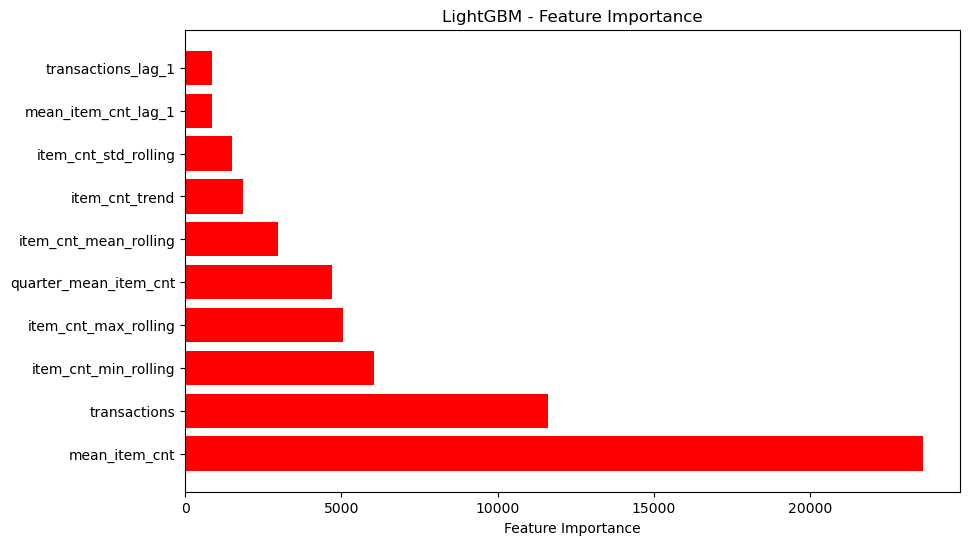

In [148]:
# Get feature importance
feature_importance = best_model_wval.feature_importance(importance_type='split')  # 'split' or 'gain'
feature_names = best_model_wval.feature_name()

# Create a DataFrame for easier plotting
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)  # Display top 10 features

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'],  color='red')
plt.xlabel('Feature Importance')
plt.title("LightGBM - Feature Importance")
plt.show()

# Deep Learning Framework using Pytorch

#### 1. Baseline LSTM using Pytorch

In [178]:
# Load sales and test data
sales_data = pd.read_csv(os.path.join(folder_path, "sales_train.csv"))
test_data = pd.read_csv(os.path.join(folder_path, "test.csv"))

# Convert the 'date' column to datetime format
sales_data['date'] = pd.to_datetime(sales_data['date'], format='%d.%m.%Y')

# Create a pivot table to aggregate sales data
sales_pivot = sales_data.pivot_table(index=['shop_id', 'item_id'], values=['item_cnt_day'],
                                     columns=['date_block_num'], fill_value=0, aggfunc='sum')

# Reset indices for easier manipulation
sales_pivot.reset_index(inplace=True)

# Merge test data with sales pivot table
merged_data = pd.merge(test_data, sales_pivot, on=['item_id', 'shop_id'], how='left')

# Fill NaN values with 0
merged_data.fillna(0, inplace=True)

# Display the first few rows of the dataset
merged_data.head()

,ID,shop_id,item_id,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)","(item_cnt_day, 10)","(item_cnt_day, 11)","(item_cnt_day, 12)","(item_cnt_day, 13)","(item_cnt_day, 14)","(item_cnt_day, 15)","(item_cnt_day, 16)","(item_cnt_day, 17)","(item_cnt_day, 18)","(item_cnt_day, 19)","(item_cnt_day, 20)","(item_cnt_day, 21)","(item_cnt_day, 22)","(item_cnt_day, 23)","(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [154]:
merged_data.drop(['shop_id','item_id','ID'],inplace = True, axis = 1)
merged_data.head()

,"(item_cnt_day, 0)","(item_cnt_day, 1)","(item_cnt_day, 2)","(item_cnt_day, 3)","(item_cnt_day, 4)","(item_cnt_day, 5)","(item_cnt_day, 6)","(item_cnt_day, 7)","(item_cnt_day, 8)","(item_cnt_day, 9)","(item_cnt_day, 10)","(item_cnt_day, 11)","(item_cnt_day, 12)","(item_cnt_day, 13)","(item_cnt_day, 14)","(item_cnt_day, 15)","(item_cnt_day, 16)","(item_cnt_day, 17)","(item_cnt_day, 18)","(item_cnt_day, 19)","(item_cnt_day, 20)","(item_cnt_day, 21)","(item_cnt_day, 22)","(item_cnt_day, 23)","(item_cnt_day, 24)","(item_cnt_day, 25)","(item_cnt_day, 26)","(item_cnt_day, 27)","(item_cnt_day, 28)","(item_cnt_day, 29)","(item_cnt_day, 30)","(item_cnt_day, 31)","(item_cnt_day, 32)","(item_cnt_day, 33)"
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [155]:
# Re-configure the Train and test
X_train = np.expand_dims(merged_data.values[:,:-1],axis = 2)
y_train = merged_data.values[:,-1:]

# Re-configure the Test
X_test = np.expand_dims(merged_data.values[:,1:],axis = 2)

# Printing the X_train and y_train
print(X_train.shape,y_train.shape,X_test.shape)

(214200, 33, 1) (214200, 1) (214200, 33, 1)


In [158]:
# Define the PyTorch model
class LSTM_Regressor_Model(nn.Module):
    def __init__(self):
        super(LSTM_Regressor_Model, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
        self.dropout = nn.Dropout(0.4)
        self.linear = nn.Linear(64, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])  # Extract the last time step output and apply dropout
        out = self.linear(out)
        return out

# Convert the data to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)

# Instantiate the model, loss function, and optimizer
lstm_model = LSTM_Regressor_Model()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(my_model.parameters(), lr=0.001)

# Train the model
for epoch in range(10):
    # Forward pass
    outputs = lstm_model(X_train_torch)
    loss = criterion(outputs, y_train_torch)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch + 1}/10], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 31.0132
Epoch [2/10], Loss: 30.9954
Epoch [3/10], Loss: 30.9705
Epoch [4/10], Loss: 30.9612
Epoch [5/10], Loss: 30.9490
Epoch [6/10], Loss: 30.9404
Epoch [7/10], Loss: 30.9302
Epoch [8/10], Loss: 30.9080
Epoch [9/10], Loss: 30.9016
Epoch [10/10], Loss: 30.8892


In [160]:
#my_model.to_pickle("LSTM_Model_Trained.pkl")# Save the model
torch.save(lstm_model.state_dict(), 'LSTM_Model_Trained.pth')

In [161]:
# # Load the model
# loaded_model = lstm_model()
# loaded_model.load_state_dict(torch.load('my_model.pth'))
# loaded_model.eval()  # Set the model to evaluation mode

In [176]:
#creating submission file 
lstm_model.eval()

X_test_torch = torch.tensor(X_test, dtype=torch.float32)

submission_lstm = lstm_model(X_test_torch).detach().numpy()

# Applying clip to the outpur
submission_lstm = submission_lstm.clip(0,20)

# creating dataframe with required columns 
submission = pd.DataFrame({'ID':test_data['ID'],'item_cnt_month':submission_lstm.ravel()})

# creating csv file from dataframe
submission.to_csv('lstm_model_preds_03_03_2024.csv',index = False)